<a href="https://colab.research.google.com/github/jimimased/ADD-audio-dataset-downloader/blob/main/risk2025ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install yfinance
!pip install numpy
!pip install matplotlib
!pip install fredapi
!pip install seaborn

Gold series found!

First few values:
1984-12-01    120.3
1985-01-01      NaN
1985-02-01      NaN
1985-03-01    104.7
1985-04-01      NaN
dtype: float64


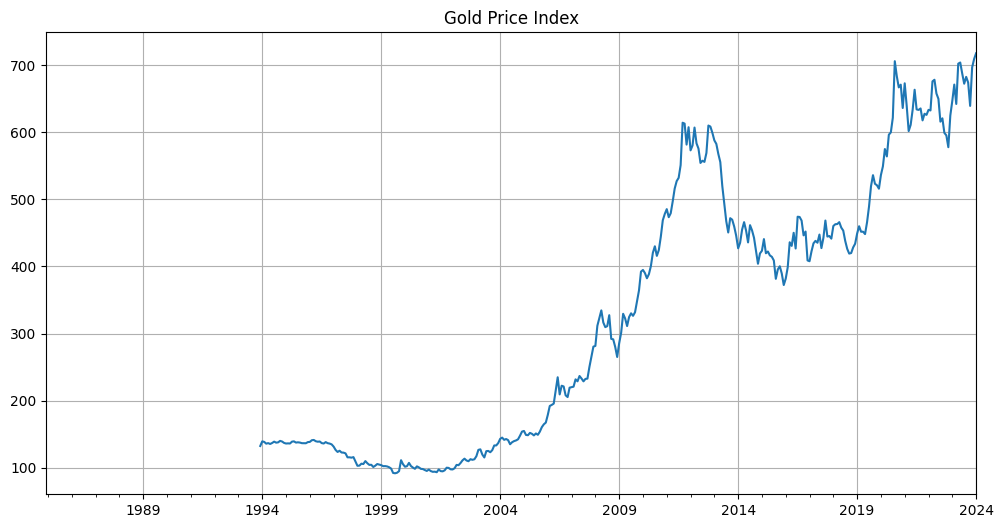

In [ ]:
!pip install fredapi pandas numpy matplotlib

import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

# Initialize FRED with the API key
fred = Fred(api_key='9edcfe0388121c02c0de5328c0d75294')

try:
    # Get gold price data using IQ12260 series
    gold = fred.get_series('IQ12260',  # Export Price Index: Nonmonetary Gold
                          observation_start='1980-01-01',
                          observation_end='2024-01-01')
    print("Gold series found!")
    print("\nFirst few values:")
    print(gold.head())

    # Quick plot to verify
    plt.figure(figsize=(12, 6))
    gold.plot()
    plt.title('Gold Price Index')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

Successfully fetched S&P 500 data
Successfully fetched NASDAQ data
Successfully fetched VIX data
Successfully fetched Baa Spread data
Successfully fetched High Yield Spread data
Successfully fetched TED Spread data
Successfully fetched 10Y Treasury data
Successfully fetched 2Y Treasury data
Successfully fetched Fed Funds data
Successfully fetched Financial Stress data
Successfully fetched NFCI data
Successfully fetched Industrial Production data
Successfully fetched CPI data
Successfully fetched Gold data

Successfully retrieved 14 out of 14 series


<ipython-input-31-626af6f47e91>:75: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data['CPI_YoY'] = market_data['CPI'].pct_change(12)
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


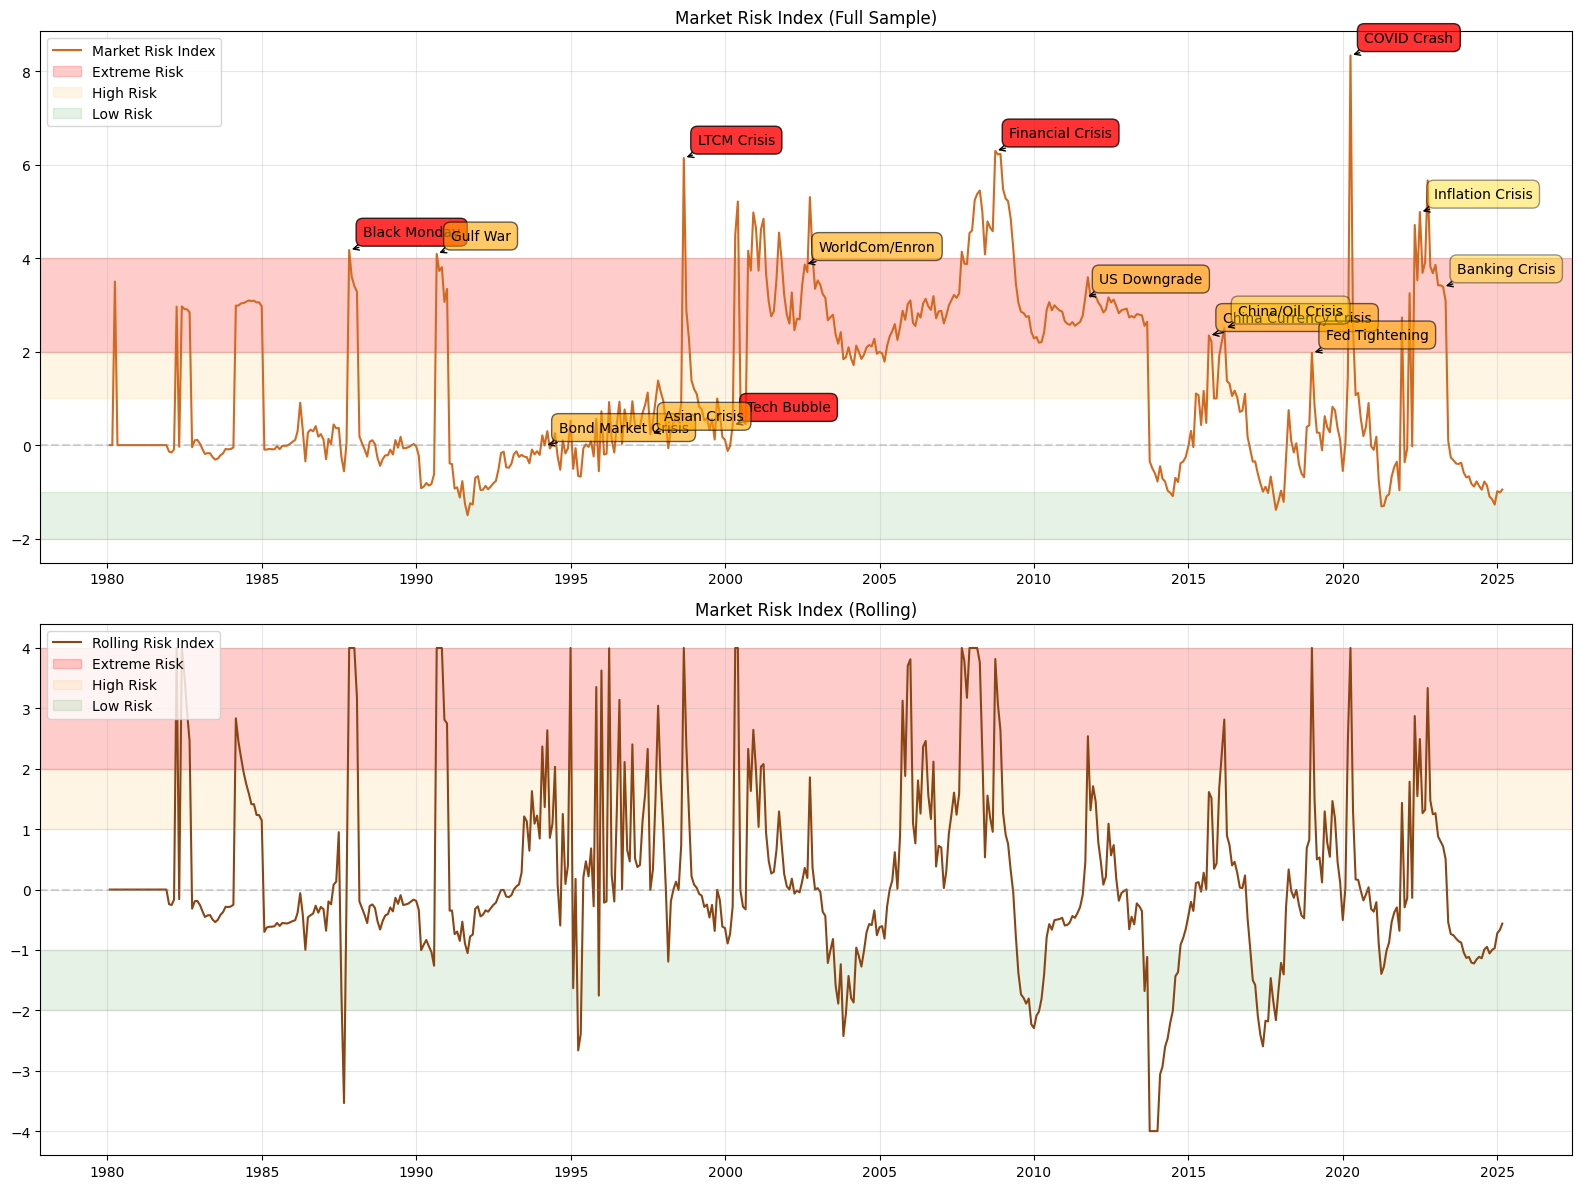

Error plotting risk indices: When stacked is True, each column must be either all positive or all negative. Column 'SP500_ret_contribution' contains both positive and negative values

Market Risk Analysis Report
Report Date: 2025-02-28
--------------------------------------------------

1. Current Risk Metrics:
Full Sample Risk Index: -0.95
Rolling Risk Index: -0.56
VIX Level: 15.3
Credit Spread: 1.46

2. Historical Context:
Full Sample Percentile: 5.4%
Rolling Percentile: 24.7%

3. Risk Status Assessment:
Status: MODERATE RISK
Assessment: Normal market conditions

4. Key Stress Indicators:
Market Drawdown: 0.00 (Percentile: 56.7%)
Credit Stress: 0.00 (Percentile: 50.1%)
VIX Level: 15.27 (Percentile: 25.6%)
Financial Conditions: -0.84 (Percentile: 4.6%)

5. Risk Contributors:

Top Risk Factors:
SP500_decline: 0.000
NASDAQ_decline: 0.000
SP500_drawdown: 0.000

Top Stabilizing Factors:
SP500_vol: -0.398
Baa_spread: -0.210
VIX: -0.115

6. Trend Analysis:
1-Month Change: 0.10
3-Month Chang

<Figure size 1600x800 with 0 Axes>

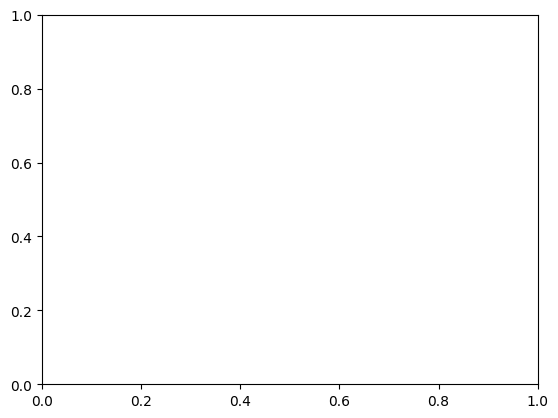

In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

FRED_API_KEY = '9edcfe0388121c02c0de5328c0d75294'

def get_market_data(start_date='1980-01-01', end_date=None):
    """Get comprehensive market data from FRED"""
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print("Downloading data from FRED...")
    try:
        fred = Fred(api_key=FRED_API_KEY)

        # Critical market indicators
        series_ids = {
            # Market Indices
            'S&P 500': 'SP500',
            'NASDAQ': 'NASDAQCOM',

            # Volatility
            'VIX': 'VIXCLS',

            # Credit Markets
            'Baa Spread': 'BAA10Y',
            'High Yield Spread': 'BAMLH0A0HYM2',
            'TED Spread': 'TEDRATE',

            # Interest Rates
            '10Y Treasury': 'GS10',
            '2Y Treasury': 'GS2',
            'Fed Funds': 'FEDFUNDS',

            # Stress Indicators
            'Financial Stress': 'STLFSI4',
            'NFCI': 'NFCI',

            # Economic Data
            'Industrial Production': 'INDPRO',
            'CPI': 'CPIAUCSL',

            # Commodities
            'Gold': 'IQ12260'
        }

        data_dict = {}
        successful_fetches = 0

        for name, series_id in series_ids.items():
            try:
                series = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
                if not series.empty:
                    data_dict[name] = series.resample('ME').last()
                    successful_fetches += 1
                    print(f"Successfully fetched {name} data")
            except Exception as e:
                print(f"Warning: Could not fetch {name} ({series_id}): {str(e)}")

        if successful_fetches == 0:
            raise Exception("No data could be retrieved from FRED")

        # Create DataFrame
        market_data = pd.DataFrame(data_dict)

        # Calculate yield curve spread
        if '10Y Treasury' in market_data.columns and '2Y Treasury' in market_data.columns:
            market_data['Yield Curve Spread'] = market_data['10Y Treasury'] - market_data['2Y Treasury']

        # Calculate real rates
        if '10Y Treasury' in market_data.columns and 'CPI' in market_data.columns:
            market_data['CPI_YoY'] = market_data['CPI'].pct_change(12)
            market_data['Real 10Y Rate'] = market_data['10Y Treasury'] - market_data['CPI_YoY']

        # Fill missing values
        market_data = market_data.ffill().bfill()

        print(f"\nSuccessfully retrieved {successful_fetches} out of {len(series_ids)} series")

        return market_data

    except Exception as e:
        print(f"Error getting data from FRED: {str(e)}")
        return None

def calculate_market_returns(df):
    """Calculate comprehensive return metrics with enhanced crash detection"""
    try:
        market_indices = ['S&P 500', 'NASDAQ']

        for col in market_indices:
            if col in df.columns:
                # Returns over multiple horizons
                df[f'{col}_ret_1m'] = df[col].pct_change()
                df[f'{col}_ret_3m'] = df[col].pct_change(3)
                df[f'{col}_ret_6m'] = df[col].pct_change(6)
                df[f'{col}_ret_12m'] = df[col].pct_change(12)

                # Volatility measures
                df[f'{col}_vol_1m'] = df[f'{col}_ret_1m'].rolling(21).std() * np.sqrt(252)
                df[f'{col}_vol_3m'] = df[f'{col}_ret_1m'].rolling(63).std() * np.sqrt(252)

                # Drawdown calculations
                rolling_max = df[col].rolling(window=252, min_periods=1).max()
                df[f'{col}_drawdown'] = df[col] / rolling_max - 1

                # Crash indicators
                df[f'{col}_crash_signal'] = ((df[f'{col}_ret_1m'] < -0.10) |
                                           (df[f'{col}_drawdown'] < -0.20)).astype(int)

                # Momentum signals
                df[f'{col}_momentum'] = df[f'{col}_ret_12m'].rolling(3).mean()

        return df
    except Exception as e:
        print(f"Error in calculate_market_returns: {str(e)}")
        return df

def rolling_zscore(series, window=60, min_periods=24):
    """Calculate rolling z-score with enhanced extreme value handling"""
    if series.empty:
        return pd.Series(index=series.index)

    rolling_mean = series.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = series.rolling(window=window, min_periods=min_periods).std()

    # Handle zero standard deviation
    rolling_std = rolling_std.replace(0, np.nan)

    zscore = (series - rolling_mean) / rolling_std

    # Non-linear transformation for extreme values
    zscore = np.sign(zscore) * np.abs(zscore) ** 1.5

    # Clip extreme values
    zscore = np.clip(zscore, -4, 4)

    return zscore.fillna(0)

def calculate_risk_indices(df):
    """Calculate comprehensive risk indices with enhanced crisis detection"""
    if df is None or df.empty:
        print("No data available for risk calculation")
        return None

    try:
        # Calculate base metrics
        df = calculate_market_returns(df)

        # Crisis detection enhancements
        window = 60  # 5-year window for baseline
        crisis_window = 20  # Shorter window for crisis detection

        # Market stress indicators
        for col in ['S&P 500', 'NASDAQ']:
            if col in df.columns:
                # Sharp declines
                df[f'{col}_decline'] = (df[f'{col}_ret_1m'] < -0.10).astype(int) * 3.0

                # Volatility spikes
                vol_threshold = df[f'{col}_vol_1m'].rolling(500).quantile(0.9)
                df[f'{col}_vol_spike'] = (df[f'{col}_vol_1m'] > vol_threshold).astype(int) * 2.0

                # Severe drawdowns
                df[f'{col}_severe_drawdown'] = (df[f'{col}_drawdown'] < -0.20).astype(int) * 3.0

        # VIX-based stress
        if 'VIX' in df.columns:
            vix_threshold = df['VIX'].rolling(500).quantile(0.9)
            df['VIX_stress'] = (df['VIX'] > vix_threshold).astype(int) * 2.5
            df['VIX_extreme'] = (df['VIX'] > df['VIX'].rolling(500).quantile(0.98)).astype(int) * 4.0

        # Credit market stress
        if 'Baa Spread' in df.columns:
            spread_threshold = df['Baa Spread'].rolling(500).quantile(0.9)
            df['Credit_stress'] = (df['Baa Spread'] > spread_threshold).astype(int) * 2.5

        # Component weights for normal conditions
        base_components = {
            # Market returns (negative weights)
            'SP500_ret': ('S&P 500_ret_12m', -2.0),
            'NASDAQ_ret': ('NASDAQ_ret_12m', -1.5),

            # Volatility
            'SP500_vol': ('S&P 500_vol_1m', 2.0),
            'VIX': ('VIX', 2.5),

            # Credit markets
            'Baa_spread': ('Baa Spread', 2.5),
            'TED_spread': ('TED Spread', 2.0),

            # Yield curve
            'Yield_curve': ('Yield Curve Spread', -1.5),

            # Additional indicators
            'Financial_stress': ('Financial Stress', 2.0),
            'Real_rate': ('Real 10Y Rate', -1.0)
        }

        # Crisis components (higher weights during stress periods)
        crisis_components = {
            'SP500_decline': ('S&P 500_decline', 3.0),
            'NASDAQ_decline': ('NASDAQ_decline', 2.5),
            'SP500_drawdown': ('S&P 500_severe_drawdown', 3.0),
            'VIX_stress': ('VIX_stress', 2.5),
            'VIX_extreme': ('VIX_extreme', 4.0),
            'Credit_stress': ('Credit_stress', 2.5)
        }

        # Calculate z-scores for base components
        zscore_dict = {}
        for name, (series_name, weight) in base_components.items():
            if series_name in df.columns:
                zscore = rolling_zscore(df[series_name], window)
                zscore_dict[name] = zscore * weight

        # Add crisis components directly (already scaled)
        for name, (series_name, weight) in crisis_components.items():
            if series_name in df.columns:
                zscore_dict[name] = df[series_name] * weight

        # Combine into risk indices
        df['Risk_Index_Base'] = pd.DataFrame(zscore_dict).mean(axis=1)

        # Add crisis overlay
        crisis_columns = [col for col in df.columns if any(x in col for x in ['decline', 'stress', 'extreme', 'drawdown'])]
        if crisis_columns:
            df['Crisis_Overlay'] = df[crisis_columns].max(axis=1)
            df['Risk_Index_Static'] = df['Risk_Index_Base'] + df['Crisis_Overlay']
        else:
            df['Risk_Index_Static'] = df['Risk_Index_Base']

        # Calculate rolling risk index
        df['Risk_Index_Rolling'] = rolling_zscore(df['Risk_Index_Static'], window=30)  # Shorter window for faster response

        # Calculate component contributions
        for name in zscore_dict.keys():
            df[f'{name}_contribution'] = zscore_dict[name] / len(zscore_dict)

        return df

    except Exception as e:
        print(f"Error calculating risk indices: {str(e)}")
        return None

def plot_risk_indices(df):
    """Plot risk indices with enhanced crisis visualization"""
    if df is None or df.empty:
        print("No data available for plotting")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

        # Static index plot
        ax1.plot(df.index, df['Risk_Index_Static'], color='#D2691E', linewidth=1.5,
                 label='Market Risk Index')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax1.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax1.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax1.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')
        ax1.set_title('Market Risk Index (Full Sample)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # Major market events with verified dates and improved categorization
        events = {
            # Severe Crises
            '1987-10': ('Black Monday', 'severe'),
            '1998-08': ('LTCM Crisis', 'severe'),
            '2000-03': ('Tech Bubble', 'severe'),
            '2008-09': ('Financial Crisis', 'severe'),
            '2020-03': ('COVID Crash', 'severe'),

            # Major Market Stress
            '1990-08': ('Gulf War', 'major'),
            '1994-02': ('Bond Market Crisis', 'major'),
            '1997-07': ('Asian Crisis', 'major'),
            '2002-07': ('WorldCom/Enron', 'major'),
            '2011-08': ('US Downgrade', 'major'),
            '2015-08': ('China Currency Crisis', 'major'),
            '2018-12': ('Fed Tightening', 'major'),

            # Significant Events
            '2016-02': ('China/Oil Crisis', 'significant'),
            '2022-06': ('Inflation Crisis', 'significant'),
            '2023-03': ('Banking Crisis', 'significant')
        }

        # Event visualization with enhanced styling
        colors = {
            'severe': '#FF0000',    # Red
            'major': '#FFA500',     # Orange
            'significant': '#FFD700' # Gold
        }
        alphas = {
            'severe': 0.8,
            'major': 0.6,
            'significant': 0.4
        }

        for date, (label, category) in events.items():
            try:
                idx = df.index.get_loc(date)
                ax1.annotate(label,
                           xy=(df.index[idx], df['Risk_Index_Static'][idx]),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5',
                                   fc=colors[category],
                                   alpha=alphas[category]),
                           arrowprops=dict(arrowstyle='->',
                                         connectionstyle='arc3,rad=0'))
            except:
                continue

        # Rolling index plot
        ax2.plot(df.index, df['Risk_Index_Rolling'], color='#8B4513', linewidth=1.5,
                 label='Rolling Risk Index')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax2.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax2.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')
        ax2.set_title('Market Risk Index (Rolling)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

        # Plot component contributions
        contribution_cols = [col for col in df.columns if col.endswith('_contribution')]
        if contribution_cols:
            plt.figure(figsize=(16, 8))
            df[contribution_cols].plot(kind='area', stacked=True, alpha=0.6)
            plt.title('Risk Index Component Contributions')
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error plotting risk indices: {str(e)}")
def print_risk_analysis(df):
    """Print comprehensive risk analysis with enhanced diagnostics"""
    if df is None or df.empty:
        print("No data available for risk analysis")
        return

    try:
        # Get latest values
        latest_date = df.index[-1]
        latest_static = df['Risk_Index_Static'].iloc[-1]
        latest_rolling = df['Risk_Index_Rolling'].iloc[-1]

        print("\nMarket Risk Analysis Report")
        print("=" * 50)
        print(f"Report Date: {latest_date.strftime('%Y-%m-%d')}")
        print("-" * 50)

        # Risk Index Values
        print("\n1. Current Risk Metrics:")
        print(f"Full Sample Risk Index: {latest_static:.2f}")
        print(f"Rolling Risk Index: {latest_rolling:.2f}")

        # Current market conditions
        if 'VIX' in df.columns:
            print(f"VIX Level: {df['VIX'].iloc[-1]:.1f}")
        if 'Baa Spread' in df.columns:
            print(f"Credit Spread: {df['Baa Spread'].iloc[-1]:.2f}")

        # Percentile Rankings
        static_percentile = stats.percentileofscore(
            df['Risk_Index_Static'].dropna(), latest_static
        )
        rolling_percentile = stats.percentileofscore(
            df['Risk_Index_Rolling'].dropna(), latest_rolling
        )

        print("\n2. Historical Context:")
        print(f"Full Sample Percentile: {static_percentile:.1f}%")
        print(f"Rolling Percentile: {rolling_percentile:.1f}%")

        # Enhanced Risk Status
        print("\n3. Risk Status Assessment:")
        # Define thresholds for different risk levels
        if latest_rolling > 3.0:
            status = "SEVERE CRISIS"
            detail = "Extreme market stress conditions - severe systemic risk"
        elif latest_rolling > 2.0:
            status = "EXTREME RISK"
            detail = "Very high market stress - significant systemic pressure"
        elif latest_rolling > 1.5:
            status = "HIGH RISK"
            detail = "Elevated market stress - potential for significant volatility"
        elif latest_rolling > 1.0:
            status = "ELEVATED RISK"
            detail = "Above-normal market stress levels"
        elif latest_rolling < -2.0:
            status = "VERY LOW RISK"
            detail = "Extremely favorable market conditions"
        elif latest_rolling < -1.0:
            status = "LOW RISK"
            detail = "Favorable market conditions - low stress levels"
        else:
            status = "MODERATE RISK"
            detail = "Normal market conditions"

        print(f"Status: {status}")
        print(f"Assessment: {detail}")

        # Stress Indicators Analysis
        print("\n4. Key Stress Indicators:")
        stress_indicators = {
            'Market Volatility': 'SP500_vol_1m',
            'Market Drawdown': 'S&P 500_drawdown',
            'Credit Stress': 'Credit_stress',
            'VIX Level': 'VIX',
            'Financial Conditions': 'Financial Stress'
        }

        for name, column in stress_indicators.items():
            if column in df.columns:
                latest_value = df[column].iloc[-1]
                percentile = stats.percentileofscore(df[column].dropna(), latest_value)
                print(f"{name}: {latest_value:.2f} (Percentile: {percentile:.1f}%)")

        # Component Analysis
        contribution_cols = [col for col in df.columns if col.endswith('_contribution')]
        if contribution_cols:
            contributions = df[contribution_cols].iloc[-1]
            print("\n5. Risk Contributors:")
            print("\nTop Risk Factors:")
            for col, value in contributions.nlargest(3).items():
                print(f"{col.replace('_contribution', '')}: {value:.3f}")
            print("\nTop Stabilizing Factors:")
            for col, value in contributions.nsmallest(3).items():
                print(f"{col.replace('_contribution', '')}: {value:.3f}")

        # Trend Analysis
        print("\n6. Trend Analysis:")
        month_change = df['Risk_Index_Rolling'].diff().iloc[-1]
        three_month_change = df['Risk_Index_Rolling'].diff(3).iloc[-1]
        six_month_change = df['Risk_Index_Rolling'].diff(6).iloc[-1]

        print(f"1-Month Change: {month_change:.2f}")
        print(f"3-Month Change: {three_month_change:.2f}")
        print(f"6-Month Change: {six_month_change:.2f}")

        # Momentum Analysis
        trend = np.sign(six_month_change)
        trend_strength = abs(six_month_change)

        print("\n7. Risk Momentum:")
        if trend > 0:
            direction = "INCREASING"
        else:
            direction = "DECREASING"

        if trend_strength > 1.0:
            strength = "STRONG"
        elif trend_strength > 0.5:
            strength = "MODERATE"
        else:
            strength = "WEAK"

        print(f"Risk Trend: {direction} ({strength})")

    except Exception as e:
        print(f"Error in risk analysis: {str(e)}")

def main():
    """Main function to run the enhanced market risk analysis"""
    try:
        # Get market data
        df = get_market_data()

        if df is not None and not df.empty:
            # Calculate risk indices
            df = calculate_risk_indices(df)

            if df is not None:
                # Create visualizations
                plot_risk_indices(df)

                # Print comprehensive analysis
                print_risk_analysis(df)
            else:
                print("Failed to calculate risk indices")
        else:
            print("Failed to retrieve market data")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime
import time

# Constants and Setup
FRED_API_KEY = '9edcfe0388121c02c0de5328c0d75294'
START_DATE = '1980-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

def get_sp500_data(max_retries=3, delay=5):
    """Get S&P 500 data with retry logic"""
    for attempt in range(max_retries):
        try:
            sp500 = yf.download('^GSPC', start=START_DATE, end=END_DATE, progress=False)['Adj Close']
            if not sp500.empty:
                return sp500.resample('ME').last()
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                print(f"Waiting {delay} seconds before retrying...")
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            continue

    # If all attempts fail, try alternative ticker
    try:
        print("Trying alternative S&P 500 ticker (SPY)...")
        spy = yf.download('SPY', start=START_DATE, end=END_DATE, progress=False)['Adj Close']
        if not spy.empty:
            return spy.resample('ME').last()
    except Exception as e:
        print(f"Alternative ticker failed: {str(e)}")

    raise ValueError("Failed to download S&P 500 data after all attempts")

def get_market_data():
    """Get market data from Yahoo Finance and FRED"""
    print("Downloading data...")

    try:
        # Get S&P 500 data
        sp500 = get_sp500_data()
        sp500.index = sp500.index.tz_localize(None)

        # Get FRED data
        fred = Fred(api_key=FRED_API_KEY)

        # Get FRED series with error handling
        def get_fred_series(series_id, name):
            try:
                return fred.get_series(series_id, observation_start=START_DATE, observation_end=END_DATE)
            except Exception as e:
                print(f"Error fetching {name} from FRED: {str(e)}")
                return pd.Series(dtype=float)

        gold = get_fred_series('IQ12260', 'Gold')
        corp_spread = get_fred_series('BAMLC0A0CM', 'Corporate Spread')
        vix = get_fred_series('VIXCLS', 'VIX')

        # Resample all FRED data to month-end
        gold = gold.resample('ME').last()
        corp_spread = corp_spread.resample('ME').last()
        vix = vix.resample('ME').last()

        # Combine into DataFrame
        df = pd.DataFrame({
            'S&P 500': sp500,
            'Gold': gold,
            'Corporate Spread': corp_spread,
            'VIX': vix
        })

        # Fill missing values
        df = df.fillna(method='ffill').fillna(method='bfill')

        if df.empty:
            raise ValueError("No data available after processing")

        return df

    except Exception as e:
        print(f"Error in get_market_data: {str(e)}")
        return None

def calculate_market_metrics(df):
    """Calculate market risk metrics"""
    try:
        if df is None or df.empty:
            return None

        # Calculate returns
        df['SP500_ret_1m'] = df['S&P 500'].pct_change()
        df['SP500_ret_12m'] = df['S&P 500'].pct_change(12)

        # Calculate drawdown
        rolling_max = df['S&P 500'].rolling(window=252, min_periods=1).max()
        df['Drawdown'] = df['S&P 500'] / rolling_max - 1

        # Volatility
        df['Volatility'] = df['SP500_ret_1m'].rolling(window=22).std() * np.sqrt(252)

        return df
    except Exception as e:
        print(f"Error in calculate_market_metrics: {str(e)}")
        return None

def calculate_risk_index(df):
    """Calculate risk index with crisis detection"""
    try:
        if df is None or df.empty:
            return None

        window = 60  # 5-year window for z-scores

        # Calculate z-scores with error handling
        def safe_zscore(series, window):
            try:
                return (series - series.rolling(window).mean()) / series.rolling(window).std()
            except:
                return pd.Series(0, index=series.index)

        # Calculate component z-scores
        df['SP500_zscore'] = safe_zscore(df['SP500_ret_12m'], window)
        df['Gold_zscore'] = safe_zscore(df['Gold'].pct_change(12), window)
        df['Spread_zscore'] = safe_zscore(df['Corporate Spread'], window)

        if 'VIX' in df.columns:
            df['VIX_zscore'] = safe_zscore(df['VIX'], window)
        else:
            df['VIX_zscore'] = 0

        # Crisis indicators
        df['Crash_signal'] = ((df['SP500_ret_1m'] < -0.10) | (df['Drawdown'] < -0.20)).astype(int) * 2

        if 'VIX' in df.columns:
            df['Stress_signal'] = (df['VIX'] > df['VIX'].rolling(500, min_periods=1).quantile(0.9)).astype(int)
        else:
            df['Stress_signal'] = 0

        # Combine into risk index
        df['Risk_Index'] = (-1.5 * df['SP500_zscore'] +
                           1.0 * df['Gold_zscore'] +
                           1.5 * df['Spread_zscore'] +
                           1.0 * df['VIX_zscore'] +
                           df['Crash_signal'] +
                           df['Stress_signal'])

        return df
    except Exception as e:
        print(f"Error in calculate_risk_index: {str(e)}")
        return None

def plot_market_data(df):
    """Plot market data with risk overlay"""
    try:
        if df is None or df.empty:
            print("No data available for plotting")
            return

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

        # Plot 1: Market Data
        ax1.semilogy(df.index, df['S&P 500'], '#8B4513', label='S&P 500', linewidth=1)
        ax1.semilogy(df.index, df['Gold'], '#B8B8B8', label='Gold', linewidth=1)
        ax1.semilogy(df.index, df['Corporate Spread'], '#D2691E', label='Corporate Spread', linewidth=1)

        ax1.grid(True, which='both', linestyle='--', alpha=0.3)
        ax1.set_title('Market Indicators')
        ax1.legend(loc='upper left')

        # Plot 2: Risk Index
        ax2.plot(df.index, df['Risk_Index'], color='#D2691E', linewidth=1.5, label='Risk Index')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax2.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax2.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')

        # Add major market events
        events = {
            '1987-10': 'Black Monday',
            '1998-08': 'LTCM Crisis',
            '2000-03': 'Tech Bubble',
            '2008-09': 'Financial Crisis',
            '2020-03': 'COVID Crash',
            '2022-06': 'Inflation Crisis'
        }

        for date, label in events.items():
            try:
                idx = df.index.get_loc(date)
                ax2.annotate(label,
                            xy=(df.index[idx], df['Risk_Index'][idx]),
                            xytext=(10, 10), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            except:
                continue

        ax2.grid(True, alpha=0.3)
        ax2.set_title('Market Risk Index')
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in plot_market_data: {str(e)}")

def print_risk_analysis(df):
    """Print current risk analysis"""
    try:
        if df is None or df.empty:
            print("No data available for analysis")
            return

        latest_risk = df['Risk_Index'].iloc[-1]
        risk_percentile = stats.percentileofscore(df['Risk_Index'].dropna(), latest_risk)

        print("\nCurrent Market Risk Analysis")
        print("=" * 50)
        print(f"Date: {df.index[-1].strftime('%Y-%m-%d')}")
        print(f"Risk Index: {latest_risk:.2f}")
        print(f"Historical Percentile: {risk_percentile:.1f}%")

        # Risk status
        if latest_risk > 2.0:
            status = "EXTREME RISK"
            detail = "Severe market stress conditions"
        elif latest_risk > 1.0:
            status = "HIGH RISK"
            detail = "Elevated market stress levels"
        elif latest_risk < -2.0:
            status = "VERY LOW RISK"
            detail = "Extremely favorable conditions"
        elif latest_risk < -1.0:
            status = "LOW RISK"
            detail = "Favorable market conditions"
        else:
            status = "MODERATE RISK"
            detail = "Normal market conditions"

        print(f"\nRisk Status: {status}")
        print(f"Assessment: {detail}")

        # Current market conditions
        print("\nCurrent Market Conditions:")
        print(f"S&P 500 12m Return: {df['SP500_ret_12m'].iloc[-1]*100:.1f}%")
        print(f"Current Drawdown: {df['Drawdown'].iloc[-1]*100:.1f}%")
        if 'VIX' in df.columns:
            print(f"VIX Level: {df['VIX'].iloc[-1]:.1f}")
        print(f"Corporate Spread: {df['Corporate Spread'].iloc[-1]:.2f}")

    except Exception as e:
        print(f"Error in print_risk_analysis: {str(e)}")

def main():
    # Get data with retry logic
    for attempt in range(3):
        try:
            df = get_market_data()
            if df is not None and not df.empty:
                break
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            time.sleep(5)

    if df is None or df.empty:
        print("Failed to get market data after all attempts")
        return

    # Calculate metrics
    df = calculate_market_metrics(df)
    if df is None:
        return

    # Calculate risk index
    df = calculate_risk_index(df)
    if df is None:
        return

    # Create visualizations
    plot_market_data(df)

    # Print analysis
    print_risk_analysis(df)

if __name__ == "__main__":
    main()

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Trying alternative S&P 500 ticker (SPY)...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Error in get_market_data: Failed to download S&P 500 data after all attempts


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Trying alternative S&P 500 ticker (SPY)...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Error in get_market_data: Failed to download S&P 500 data after all attempts


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Trying alternative S&P 500 ticker (SPY)...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Error in get_market_data: Failed to download S&P 500 data after all attempts
Failed to get market data after all attempts


Successfully fetched S&P 500 data
Successfully fetched NASDAQ data
Successfully fetched VIX data
Successfully fetched Baa Spread data
Successfully fetched High Yield Spread data
Successfully fetched TED Spread data
Successfully fetched 10Y Treasury data
Successfully fetched 2Y Treasury data
Successfully fetched Fed Funds data
Successfully fetched Financial Stress data
Successfully fetched NFCI data
Successfully fetched Industrial Production data
Successfully fetched CPI data
Successfully fetched Unemployment data
Successfully fetched Gold data
Successfully fetched Oil data
Successfully fetched Dollar Index data

Successfully retrieved 17 out of 17 series

Data shape: (542, 20)

Available columns: ['S&P 500', 'NASDAQ', 'VIX', 'Baa Spread', 'High Yield Spread', 'TED Spread', '10Y Treasury', '2Y Treasury', 'Fed Funds', 'Financial Stress', 'NFCI', 'Industrial Production', 'CPI', 'Unemployment', 'Gold', 'Oil', 'Dollar Index', 'Yield Curve Spread', 'CPI_YoY', 'Real 10Y Rate']


<ipython-input-29-c18481eae834>:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data['CPI_YoY'] = market_data['CPI'].pct_change(12)
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


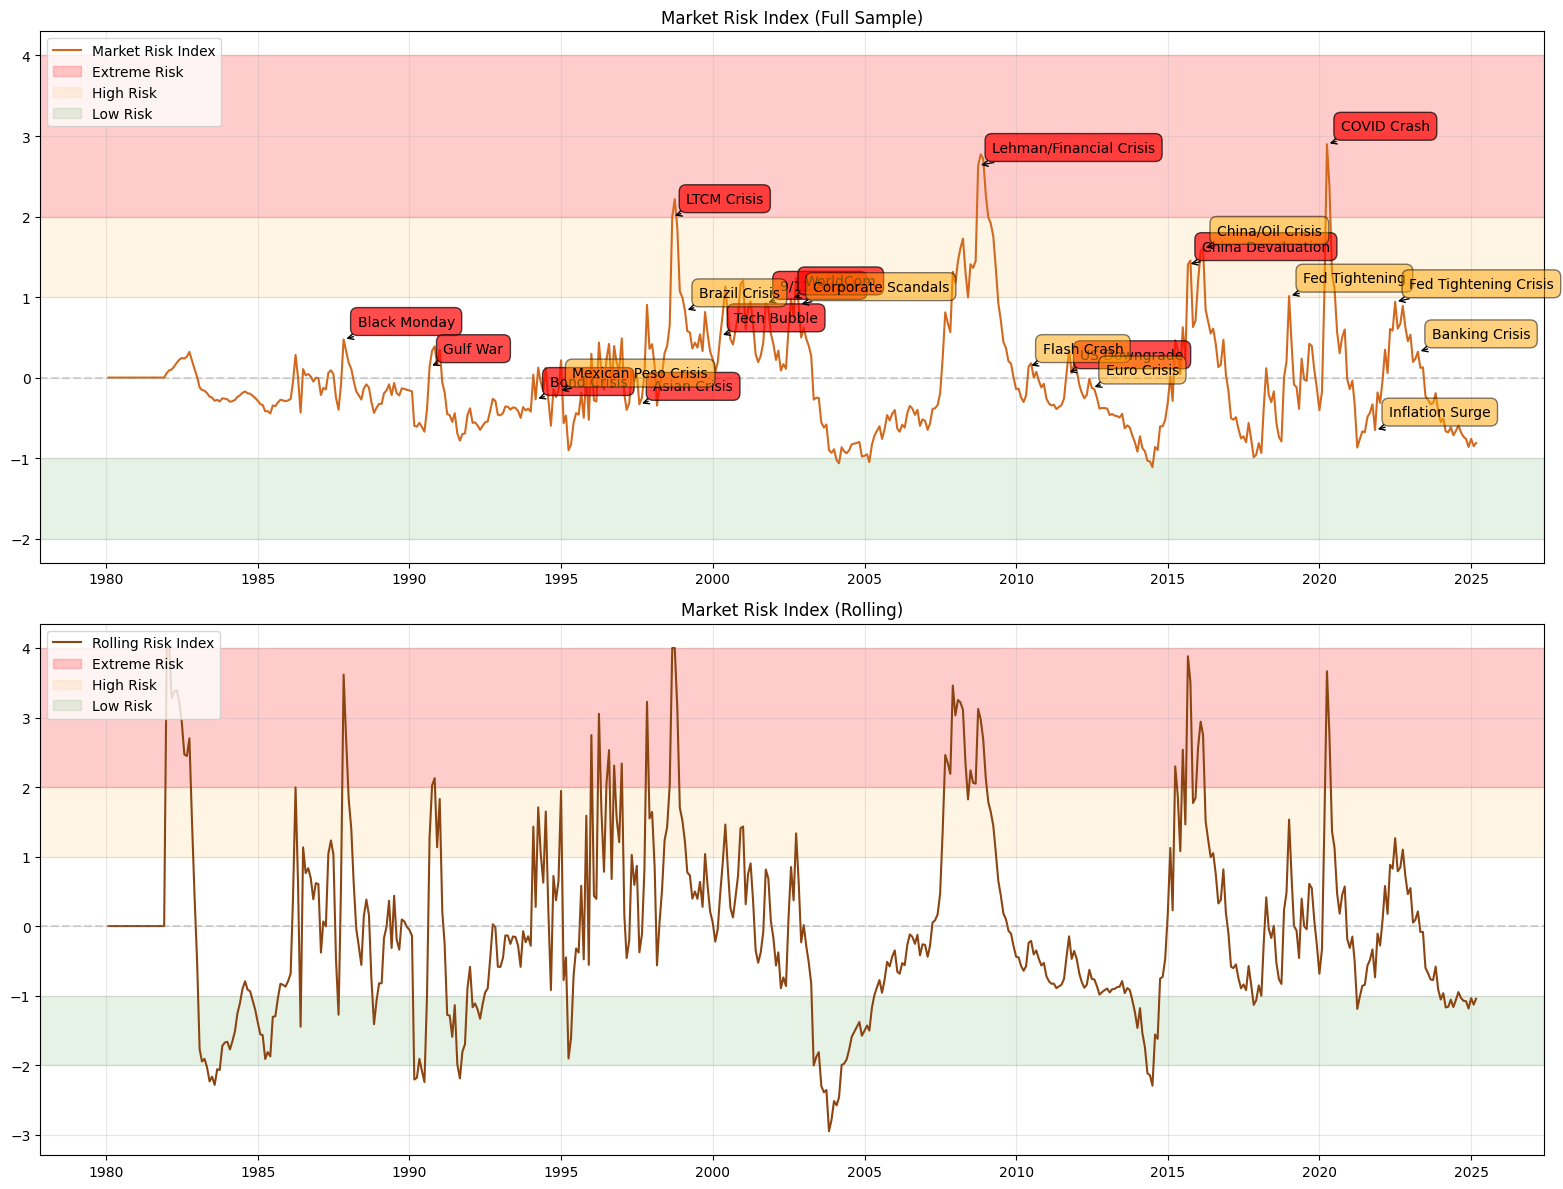

Error plotting risk indices: When stacked is True, each column must be either all positive or all negative. Column 'SP500_ret_contribution' contains both positive and negative values

Market Risk Analysis Report
Report Date: 2025-02-28
--------------------------------------------------

1. Risk Index Readings:
Full Sample Risk Index: -0.81
Rolling Risk Index: -1.04

2. Historical Context:
Full Sample Percentile: 6.3%
Rolling Percentile: 18.5%

3. Current Risk Status:
Status: LOW RISK
Assessment: Favorable market conditions

4. Component Analysis:

Top Risk Contributors:
Gold: 0.057
Oil: 0.000
Dollar: 0.000

Top Risk Reducers:
SP500_vol: -0.182
Baa_spread: -0.145
HY_spread: -0.110

5. Recent Changes:
1-Month Change: 0.09
3-Month Change: 0.14

6. Trend Analysis:
6-Month vs 12-Month Trend: -0.01


<Figure size 1600x800 with 0 Axes>

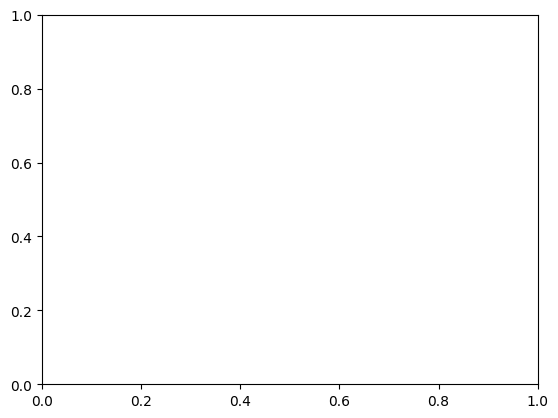

In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

FRED_API_KEY = '9edcfe0388121c02c0de5328c0d75294'

def get_market_data(start_date='1980-01-01', end_date=None):
    """Get comprehensive market data from FRED with expanded indicators"""
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print("Downloading data from FRED...")
    try:
        fred = Fred(api_key=FRED_API_KEY)

        # Expanded series with more comprehensive coverage
        series_ids = {
            # Market Indices
            'S&P 500': 'SP500',
            'NASDAQ': 'NASDAQCOM',

            # Volatility
            'VIX': 'VIXCLS',

            # Credit Markets
            'Baa Spread': 'BAA10Y',  # Moody's Baa Corporate Bond - 10Y Treasury
            'High Yield Spread': 'BAMLH0A0HYM2',  # BofA High Yield Spread
            'TED Spread': 'TEDRATE',

            # Interest Rates
            '10Y Treasury': 'GS10',  # 10-Year Treasury Rate
            '2Y Treasury': 'GS2',    # 2-Year Treasury Rate
            'Fed Funds': 'FEDFUNDS',

            # Financial Conditions
            'Financial Stress': 'STLFSI4',  # St. Louis Fed Financial Stress Index
            'NFCI': 'NFCI',         # Chicago Fed National Financial Conditions Index

            # Economic Indicators
            'Industrial Production': 'INDPRO',
            'CPI': 'CPIAUCSL',
            'Unemployment': 'UNRATE',

            # Commodities and FX
            'Gold': 'IQ12260',  # Gold Export Price Index
            'Oil': 'DCOILWTICO',  # WTI Crude Oil Price

            # International
            'Dollar Index': 'TWEXB', # Trade Weighted US Dollar Index
        }

        data_dict = {}
        successful_fetches = 0

        for name, series_id in series_ids.items():
            try:
                series = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
                if not series.empty:
                    data_dict[name] = series.resample('ME').last()
                    successful_fetches += 1
                    print(f"Successfully fetched {name} data")
            except Exception as e:
                print(f"Warning: Could not fetch {name} ({series_id}): {str(e)}")

        if successful_fetches == 0:
            raise Exception("No data could be retrieved from FRED")

        # Create DataFrame
        market_data = pd.DataFrame(data_dict)

        # Calculate yield curve spread
        if '10Y Treasury' in market_data.columns and '2Y Treasury' in market_data.columns:
            market_data['Yield Curve Spread'] = market_data['10Y Treasury'] - market_data['2Y Treasury']

        # Calculate real rates (if CPI available)
        if '10Y Treasury' in market_data.columns and 'CPI' in market_data.columns:
            market_data['CPI_YoY'] = market_data['CPI'].pct_change(12)
            market_data['Real 10Y Rate'] = market_data['10Y Treasury'] - market_data['CPI_YoY']

        # Fill missing values using forward fill then backward fill
        market_data = market_data.ffill().bfill()

        print(f"\nSuccessfully retrieved {successful_fetches} out of {len(series_ids)} series")
        print("\nData shape:", market_data.shape)
        print("\nAvailable columns:", market_data.columns.tolist())

        return market_data

    except Exception as e:
        print(f"Error getting data from FRED: {str(e)}")
        return None

def calculate_market_returns(df):
    """Calculate comprehensive return and volatility metrics"""
    return_windows = [1, 3, 6, 12]  # Months
    volatility_window = 22  # Trading days

    market_indices = ['S&P 500', 'NASDAQ']

    for col in market_indices:
        if col in df.columns:
            # Calculate returns over multiple horizons
            for window in return_windows:
                df[f'{col}_ret_{window}m'] = df[col].pct_change(window)

            # Calculate rolling volatility
            df[f'{col}_vol'] = (
                df[col].pct_change()
                .rolling(window=volatility_window)
                .std() * np.sqrt(252)
            )

            # Calculate drawdown
            rolling_max = df[col].rolling(window=252, min_periods=1).max()
            df[f'{col}_drawdown'] = df[col] / rolling_max - 1

            # Calculate 12-month momentum
            df[f'{col}_momentum'] = df[col].pct_change(12)

    return df

def rolling_zscore(series, window=60, min_periods=24):
    """Calculate rolling z-score with robust handling"""
    if series.empty:
        return pd.Series(index=series.index)

    rolling_mean = series.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = series.rolling(window=window, min_periods=min_periods).std()

    # Handle zero standard deviation
    rolling_std = rolling_std.replace(0, np.nan)

    zscore = (series - rolling_mean) / rolling_std

    # Clip extreme values
    zscore = np.clip(zscore, -4, 4)

    return zscore.fillna(0)

def get_regime_weights(df):
    """Calculate dynamic weights based on market regime"""
    weights = {}

    # Base weights
    base_weights = {
        'Market_ret': -1.5,      # Market returns
        'Market_vol': 1.25,      # Market volatility
        'VIX': 1.5,             # Implied volatility
        'Credit': 2.0,          # Credit spreads
        'Yield_curve': 1.0,     # Yield curve
        'Financial_stress': 2.0, # Financial stress indices
        'Economic': 1.0,        # Economic indicators
        'International': 0.75    # International factors
    }

    # Identify current regime
    if 'VIX' in df.columns:
        vix_percentile = df['VIX'].iloc[-1] / df['VIX'].quantile(0.95)

        # Adjust weights based on volatility regime
        regime_multiplier = 1.0 + 0.5 * (vix_percentile - 0.5)
        regime_multiplier = np.clip(regime_multiplier, 0.5, 2.0)

        # Increase importance of volatility and credit in high stress periods
        weights = {k: v * regime_multiplier if k in ['Market_vol', 'VIX', 'Credit']
                  else v for k, v in base_weights.items()}
    else:
        weights = base_weights

    return weights

def calculate_risk_indices(df):
    """Calculate comprehensive risk indices with dynamic weights"""
    if df is None or df.empty:
        print("No data available for risk calculation")
        return None

    try:
        # Calculate base metrics
        df = calculate_market_returns(df)

        # Get regime-based weights
        weights = get_regime_weights(df)

        # Calculate z-scores for all components
        window = 60  # 5-year window

        component_groups = {
            # Market returns (negative weights as higher returns = lower risk)
            'Market_returns': {
                'SP500_ret': ('S&P 500_ret_12m', weights['Market_ret']),
                'NASDAQ_ret': ('NASDAQ_ret_12m', weights['Market_ret'] * 0.75)
            },

            # Volatility measures
            'Volatility': {
                'SP500_vol': ('S&P 500_vol', weights['Market_vol']),
                'VIX_level': ('VIX', weights['VIX'])
            },

            # Credit markets
            'Credit': {
                'Baa_spread': ('Baa Spread', weights['Credit']),
                'HY_spread': ('High Yield Spread', weights['Credit'] * 0.75),
                'TED_spread': ('TED Spread', weights['Credit'] * 0.5)
            },

            # Interest rates and yield curve
            'Rates': {
                'Yield_curve': ('Yield Curve Spread', -weights['Yield_curve']),
                'Real_rate': ('Real 10Y Rate', -weights['Yield_curve'] * 0.5)
            },

            # Financial conditions
            'Financial': {
                'Fin_stress': ('Financial Stress', weights['Financial_stress']),
                'NFCI': ('NFCI', weights['Financial_stress'] * 0.75)
            },

            # Economic indicators
            'Economic': {
                'IP_growth': ('Industrial Production', -weights['Economic']),
                'Unemployment': ('Unemployment', weights['Economic'])
            },

            # International factors
            'International': {
                'Dollar': ('Dollar Index', weights['International']),
                'Gold': ('Gold', weights['International'] * 0.5),
                'Oil': ('Oil', weights['International'] * 0.5)
            }
        }

        # Calculate z-scores and weighted components
        zscore_dict = {}
        for group, components in component_groups.items():
            for name, (series_name, weight) in components.items():
                if series_name in df.columns:
                    zscore_dict[name] = rolling_zscore(df[series_name], window) * weight

        # Combine into risk indices
        df['Risk_Index_Static'] = pd.DataFrame(zscore_dict).mean(axis=1)

        # Calculate rolling risk index
        df['Risk_Index_Rolling'] = rolling_zscore(df['Risk_Index_Static'], window)

        # Calculate component contributions
        for name in zscore_dict.keys():
            df[f'{name}_contribution'] = zscore_dict[name] / len(zscore_dict)

        return df
    except Exception as e:
        print(f"Error calculating risk indices: {str(e)}")
        return None

def plot_risk_indices(df):
    """Plot risk indices with comprehensive market events"""
    if df is None or df.empty:
        print("No data available for plotting")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

        # Static index plot
        ax1.plot(df.index, df['Risk_Index_Static'], color='#D2691E', linewidth=1.5,
                 label='Market Risk Index')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax1.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax1.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax1.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')
        ax1.set_title('Market Risk Index (Full Sample)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # Comprehensive market events dictionary
        events = {
            # Major Crises
            '1987-10': ('Black Monday', 'major'),
            '1990-08': ('Gulf War', 'major'),
            '1994-02': ('Bond Crisis', 'major'),
            '1997-07': ('Asian Crisis', 'major'),
            '1998-08': ('LTCM Crisis', 'major'),
            '2000-03': ('Tech Bubble', 'major'),
            '2001-09': ('9/11 Attack', 'major'),
            '2002-07': ('WorldCom', 'major'),
            '2008-09': ('Lehman/Financial Crisis', 'major'),
            '2011-08': ('US Downgrade', 'major'),
            '2015-08': ('China Devaluation', 'major'),
            '2020-03': ('COVID Crash', 'major'),

            # Market Stress Events
            '1994-11': ('Mexican Peso Crisis', 'stress'),
            '1999-01': ('Brazil Crisis', 'stress'),
            '2002-10': ('Corporate Scandals', 'stress'),
            '2010-05': ('Flash Crash', 'stress'),
            '2012-06': ('Euro Crisis', 'stress'),
            '2016-02': ('China/Oil Crisis', 'stress'),
            '2018-12': ('Fed Tightening', 'stress'),
            '2021-10': ('Inflation Surge', 'stress'),
            '2022-06': ('Fed Tightening Crisis', 'stress'),
            '2023-03': ('Banking Crisis', 'stress')
        }

        # Plot events with different styles based on category
        colors = {'major': 'red', 'stress': 'orange'}
        alphas = {'major': 0.7, 'stress': 0.5}

        for date, (label, category) in events.items():
            try:
                idx = df.index.get_loc(date)
                ax1.annotate(label,
                           xy=(df.index[idx], df['Risk_Index_Static'][idx]),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5',
                                   fc=colors[category],
                                   alpha=alphas[category]),
                           arrowprops=dict(arrowstyle='->',
                                         connectionstyle='arc3,rad=0'))
            except:
                continue

        # Rolling index plot
        ax2.plot(df.index, df['Risk_Index_Rolling'], color='#8B4513', linewidth=1.5,
                 label='Rolling Risk Index')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax2.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax2.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')
        ax2.set_title('Market Risk Index (Rolling)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

        # Plot component contributions
        contribution_cols = [col for col in df.columns if col.endswith('_contribution')]
        if contribution_cols:
            plt.figure(figsize=(16, 8))
            df[contribution_cols].plot(kind='area', stacked=True, alpha=0.6)
            plt.title('Risk Index Component Contributions')
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error plotting risk indices: {str(e)}")

def print_risk_analysis(df):
    """Print comprehensive risk analysis"""
    if df is None or df.empty:
        print("No data available for risk analysis")
        return

    try:
        # Get latest values
        latest_date = df.index[-1]
        latest_static = df['Risk_Index_Static'].iloc[-1]
        latest_rolling = df['Risk_Index_Rolling'].iloc[-1]

        print("\nMarket Risk Analysis Report")
        print("=" * 50)
        print(f"Report Date: {latest_date.strftime('%Y-%m-%d')}")
        print("-" * 50)

        # Risk Index Values
        print("\n1. Risk Index Readings:")
        print(f"Full Sample Risk Index: {latest_static:.2f}")
        print(f"Rolling Risk Index: {latest_rolling:.2f}")

        # Percentile Rankings
        static_percentile = stats.percentileofscore(
            df['Risk_Index_Static'].dropna(), latest_static
        )
        rolling_percentile = stats.percentileofscore(
            df['Risk_Index_Rolling'].dropna(), latest_rolling
        )

        print("\n2. Historical Context:")
        print(f"Full Sample Percentile: {static_percentile:.1f}%")
        print(f"Rolling Percentile: {rolling_percentile:.1f}%")

        # Risk Status with more granular thresholds
        print("\n3. Current Risk Status:")
        if latest_rolling > 2.5:
            status = "EXTREME RISK"
            detail = "Severe market stress conditions"
        elif latest_rolling > 1.5:
            status = "HIGH RISK"
            detail = "Significant market stress"
        elif latest_rolling > 0.5:
            status = "ELEVATED RISK"
            detail = "Above-normal market stress"
        elif latest_rolling < -2.0:
            status = "VERY LOW RISK"
            detail = "Exceptionally favorable conditions"
        elif latest_rolling < -1.0:
            status = "LOW RISK"
            detail = "Favorable market conditions"
        else:
            status = "MODERATE RISK"
            detail = "Normal market conditions"

        print(f"Status: {status}")
        print(f"Assessment: {detail}")

        # Component Analysis
        contribution_cols = [col for col in df.columns if col.endswith('_contribution')]
        if contribution_cols:
            contributions = df[contribution_cols].iloc[-1]
            print("\n4. Component Analysis:")
            print("\nTop Risk Contributors:")
            for col, value in contributions.nlargest(3).items():
                print(f"{col.replace('_contribution', '')}: {value:.3f}")
            print("\nTop Risk Reducers:")
            for col, value in contributions.nsmallest(3).items():
                print(f"{col.replace('_contribution', '')}: {value:.3f}")

        # Recent Changes
        print("\n5. Recent Changes:")
        month_change = df['Risk_Index_Rolling'].diff().iloc[-1]
        three_month_change = df['Risk_Index_Rolling'].diff(3).iloc[-1]
        print(f"1-Month Change: {month_change:.2f}")
        print(f"3-Month Change: {three_month_change:.2f}")

        # Trend Analysis
        trend = df['Risk_Index_Rolling'].tail(6).mean() - df['Risk_Index_Rolling'].tail(12).mean()
        print("\n6. Trend Analysis:")
        print(f"6-Month vs 12-Month Trend: {trend:.2f}")

    except Exception as e:
        print(f"Error in risk analysis: {str(e)}")

def main():
    """Main function to run the market risk analysis"""
    try:
        # Get market data
        df = get_market_data()

        if df is not None and not df.empty:
            # Calculate risk indices
            df = calculate_risk_indices(df)

            if df is not None:
                # Create visualizations
                plot_risk_indices(df)

                # Print analysis
                print_risk_analysis(df)
            else:
                print("Failed to calculate risk indices")
        else:
            print("Failed to retrieve market data")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

Successfully fetched S&P 500 data
Successfully fetched NASDAQ data
Successfully fetched Gold data
Successfully fetched VIX data
Successfully fetched Corporate Spread data
Successfully fetched TED Spread data
Successfully fetched Financial Stress data
Successfully fetched 10Y Treasury data
Successfully fetched Fed Funds data
Successfully fetched Mortgage Rate data
Successfully fetched Industrial Production data
Successfully fetched CPI data

Successfully retrieved 12 out of 12 series

Data shape: (542, 12)

Available columns: ['S&P 500', 'NASDAQ', 'Gold', 'VIX', 'Corporate Spread', 'TED Spread', 'Financial Stress', '10Y Treasury', 'Fed Funds', 'Mortgage Rate', 'Industrial Production', 'CPI']


/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


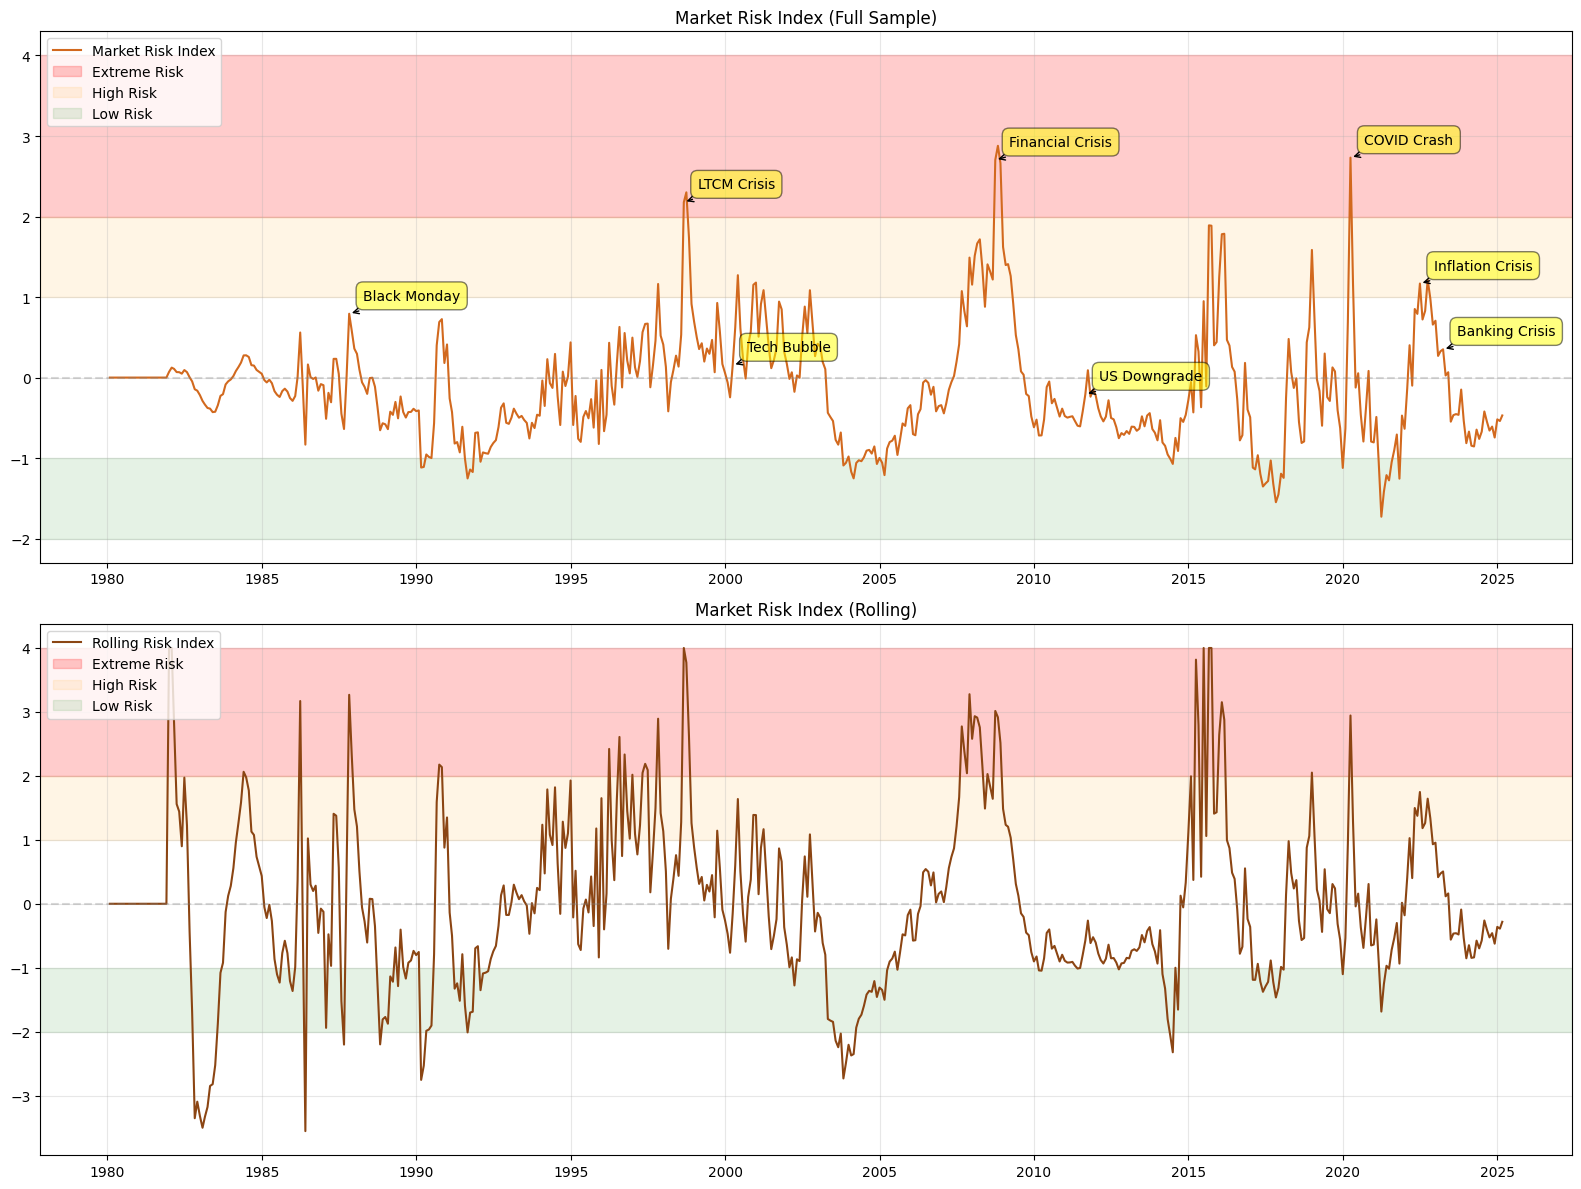

Error plotting risk indices: When stacked is True, each column must be either all positive or all negative. Column 'SP500_ret_contribution' contains both positive and negative values

Market Risk Analysis Report
Report Date: 2025-02-28
--------------------------------------------------

1. Risk Index Readings:
Full Sample Risk Index: -0.47
Rolling Risk Index: -0.28

2. Historical Context:
Full Sample Percentile: 33.9%
Rolling Percentile: 44.8%

3. Current Risk Status:
Status: MODERATE RISK
Assessment: Normal market conditions

4. Component Analysis:

Top Risk Contributors:
Treasury_10Y: 0.138
NASDAQ_ret: -0.029
TED_spread: -0.035

Top Risk Reducers:
Corp_spread: -0.250
VIX: -0.139
Financial_Stress: -0.090

5. Recent Changes:
1-Month Change: 0.11
3-Month Change: 0.34


<Figure size 1600x800 with 0 Axes>

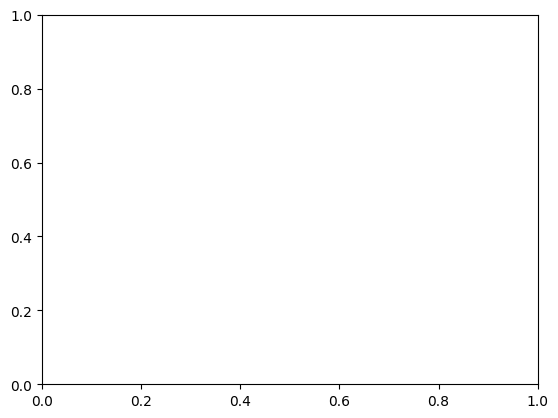

In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

FRED_API_KEY = '9edcfe0388121c02c0de5328c0d75294'

def get_market_data(start_date='1980-01-01', end_date=None):
    """Get comprehensive market data from FRED"""
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print("Downloading data from FRED...")
    try:
        fred = Fred(api_key=FRED_API_KEY)

        # Market indices with verified working series IDs
        series_ids = {
            'S&P 500': 'SP500',
            'NASDAQ': 'NASDAQCOM',
            'Gold': 'IQ12260',  # Export Price Index: Nonmonetary Gold
            'VIX': 'VIXCLS',
            'Corporate Spread': 'BAA10Y',
            'TED Spread': 'TEDRATE',
            'Financial Stress': 'STLFSI4',
            '10Y Treasury': 'GS10',
            'Fed Funds': 'FEDFUNDS',
            'Mortgage Rate': 'MORTGAGE30US',
            'Industrial Production': 'INDPRO',
            'CPI': 'CPIAUCSL'
        }

        data_dict = {}
        successful_fetches = 0

        for name, series_id in series_ids.items():
            try:
                series = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
                if not series.empty:
                    data_dict[name] = series.resample('ME').last()
                    successful_fetches += 1
                    print(f"Successfully fetched {name} data")
            except Exception as e:
                print(f"Warning: Could not fetch {name} ({series_id}): {str(e)}")

        if successful_fetches == 0:
            raise Exception("No data could be retrieved from FRED")

        # Create DataFrame
        market_data = pd.DataFrame(data_dict)

        # Fill missing values
        market_data = market_data.ffill().bfill()

        print(f"\nSuccessfully retrieved {successful_fetches} out of {len(series_ids)} series")
        print("\nData shape:", market_data.shape)
        print("\nAvailable columns:", market_data.columns.tolist())

        return market_data

    except Exception as e:
        print(f"Error getting data from FRED: {str(e)}")
        return None

def calculate_market_returns(df):
    """Calculate comprehensive return metrics"""
    return_windows = [1, 3, 6, 12]  # Months
    volatility_window = 22  # Trading days

    # List of market indices that should have returns calculated
    market_indices = ['S&P 500', 'NASDAQ']

    for col in market_indices:
        if col in df.columns:
            # Calculate returns over multiple horizons
            for window in return_windows:
                df[f'{col}_ret_{window}m'] = df[col].pct_change(window)

            # Calculate volatility
            df[f'{col}_vol'] = (
                df[col].pct_change()
                .rolling(window=volatility_window)
                .std() * np.sqrt(252)
            )

            # Calculate drawdown
            rolling_max = df[col].rolling(window=252, min_periods=1).max()
            df[f'{col}_drawdown'] = df[col] / rolling_max - 1

    return df

def rolling_zscore(series, window=60, min_periods=24):
    """Calculate rolling z-score with robust handling"""
    if series.empty:
        return pd.Series(index=series.index)

    rolling_mean = series.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = series.rolling(window=window, min_periods=min_periods).std()

    # Handle zero standard deviation
    rolling_std = rolling_std.replace(0, np.nan)

    zscore = (series - rolling_mean) / rolling_std

    # Clip extreme values
    zscore = np.clip(zscore, -4, 4)

    return zscore.fillna(0)

def calculate_risk_indices(df):
    """Calculate comprehensive risk indices"""
    if df is None or df.empty:
        print("No data available for risk calculation")
        return None

    try:
        # Calculate base metrics
        df = calculate_market_returns(df)

        # Calculate z-scores for all components
        window = 60  # 5-year window

        # Components dictionary with weights
        components = {}

        # Market components
        if 'S&P 500' in df.columns:
            components['SP500_ret'] = ('S&P 500_ret_12m', -1.5)
        if 'NASDAQ' in df.columns:
            components['NASDAQ_ret'] = ('NASDAQ_ret_12m', -1.0)

        # Volatility and stress indicators
        if 'VIX' in df.columns:
            components['VIX'] = ('VIX', 1.25)
        if 'Financial Stress' in df.columns:
            components['Financial_Stress'] = ('Financial Stress', 1.0)

        # Interest rates and spreads
        if 'Corporate Spread' in df.columns:
            components['Corp_spread'] = ('Corporate Spread', 1.5)
        if 'TED Spread' in df.columns:
            components['TED_spread'] = ('TED Spread', 1.0)
        if '10Y Treasury' in df.columns:
            components['Treasury_10Y'] = ('10Y Treasury', 0.75)

        # Calculate z-scores for all components
        zscore_dict = {}
        for name, (series_name, weight) in components.items():
            if series_name in df.columns:
                zscore_dict[name] = rolling_zscore(df[series_name], window) * weight

        # Combine into risk indices
        df['Risk_Index_Static'] = pd.DataFrame(zscore_dict).mean(axis=1)

        # Calculate rolling risk index
        df['Risk_Index_Rolling'] = rolling_zscore(df['Risk_Index_Static'], window)

        # Calculate component contributions
        for name in zscore_dict.keys():
            df[f'{name}_contribution'] = zscore_dict[name] / len(components)

        return df

    except Exception as e:
        print(f"Error calculating risk indices: {str(e)}")
        return None

def plot_risk_indices(df):
    """Plot risk indices with comprehensive market events"""
    if df is None or df.empty:
        print("No data available for plotting")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

        # Static index plot
        ax1.plot(df.index, df['Risk_Index_Static'], color='#D2691E', linewidth=1.5,
                 label='Market Risk Index')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax1.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax1.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax1.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')
        ax1.set_title('Market Risk Index (Full Sample)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # Market events dictionary
        events = {
            '1987-10': ('Black Monday', 'major'),
            '1998-08': ('LTCM Crisis', 'financial'),
            '2000-03': ('Tech Bubble', 'major'),
            '2008-09': ('Financial Crisis', 'major'),
            '2011-08': ('US Downgrade', 'financial'),
            '2020-03': ('COVID Crash', 'major'),
            '2022-06': ('Inflation Crisis', 'financial'),
            '2023-03': ('Banking Crisis', 'financial')
        }

        # Plot events
        for date, (label, category) in events.items():
            try:
                idx = df.index.get_loc(date)
                color = 'red' if category == 'major' else 'orange'
                ax1.annotate(label,
                           xy=(df.index[idx], df['Risk_Index_Static'][idx]),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            except:
                continue

        # Rolling index plot
        ax2.plot(df.index, df['Risk_Index_Rolling'], color='#8B4513', linewidth=1.5,
                 label='Rolling Risk Index')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(2.0, 4.0, color='red', alpha=0.2, label='Extreme Risk')
        ax2.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk')
        ax2.axhspan(-2.0, -1.0, color='green', alpha=0.1, label='Low Risk')
        ax2.set_title('Market Risk Index (Rolling)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

        # Plot component contributions
        contribution_cols = [col for col in df.columns if col.endswith('_contribution')]
        if contribution_cols:
            plt.figure(figsize=(16, 8))
            df[contribution_cols].plot(kind='area', stacked=True, alpha=0.6)
            plt.title('Risk Index Component Contributions')
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error plotting risk indices: {str(e)}")

def print_risk_analysis(df):
    """Print comprehensive risk analysis"""
    if df is None or df.empty:
        print("No data available for risk analysis")
        return

    try:
        # Get latest values
        latest_date = df.index[-1]
        latest_static = df['Risk_Index_Static'].iloc[-1]
        latest_rolling = df['Risk_Index_Rolling'].iloc[-1]

        print("\nMarket Risk Analysis Report")
        print("=" * 50)
        print(f"Report Date: {latest_date.strftime('%Y-%m-%d')}")
        print("-" * 50)

        # Risk Index Values
        print("\n1. Risk Index Readings:")
        print(f"Full Sample Risk Index: {latest_static:.2f}")
        print(f"Rolling Risk Index: {latest_rolling:.2f}")

        # Percentile Rankings
        static_percentile = stats.percentileofscore(
            df['Risk_Index_Static'].dropna(), latest_static
        )
        rolling_percentile = stats.percentileofscore(
            df['Risk_Index_Rolling'].dropna(), latest_rolling
        )

        print("\n2. Historical Context:")
        print(f"Full Sample Percentile: {static_percentile:.1f}%")
        print(f"Rolling Percentile: {rolling_percentile:.1f}%")

        # Risk Status
        print("\n3. Current Risk Status:")
        if latest_rolling > 2.0:
            status = "EXTREME RISK"
            detail = "Market conditions indicate severe stress"
        elif latest_rolling > 1.0:
            status = "HIGH RISK"
            detail = "Elevated risk levels warrant caution"
        elif latest_rolling < -2.0:
            status = "VERY LOW RISK"
            detail = "Market conditions extremely favorable"
        elif latest_rolling < -1.0:
            status = "LOW RISK"
            detail = "Market conditions favorable"
        else:
            status = "MODERATE RISK"
            detail = "Normal market conditions"

        print(f"Status: {status}")
        print(f"Assessment: {detail}")

        # Component Analysis
        contribution_cols = [col for col in df.columns if col.endswith('_contribution')]
        if contribution_cols:
            contributions = df[contribution_cols].iloc[-1]
            print("\n4. Component Analysis:")
            print("\nTop Risk Contributors:")
            for col, value in contributions.nlargest(3).items():
                print(f"{col.replace('_contribution', '')}: {value:.3f}")
            print("\nTop Risk Reducers:")
            for col, value in contributions.nsmallest(3).items():
                print(f"{col.replace('_contribution', '')}: {value:.3f}")

        # Recent Changes
        print("\n5. Recent Changes:")
        month_change = df['Risk_Index_Rolling'].diff().iloc[-1]
        three_month_change = df['Risk_Index_Rolling'].diff(3).iloc[-1]
        print(f"1-Month Change: {month_change:.2f}")
        print(f"3-Month Change: {three_month_change:.2f}")

    except Exception as e:
        print(f"Error in risk analysis: {str(e)}")

def main():
    """Main function to run the market risk analysis"""
    try:
        # Get market data
        df = get_market_data()

        if df is not None and not df.empty:
            # Calculate risk indices
            df = calculate_risk_indices(df)

            if df is not None:
                # Create visualizations
                plot_risk_indices(df)

                # Print analysis
                print_risk_analysis(df)
            else:
                print("Failed to calculate risk indices")
        else:
            print("Failed to retrieve market data")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

<ipython-input-20-6764f20d2b93>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_data = market_data.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))



Data Summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483 entries, 1984-12-31 to 2025-02-28
Freq: ME
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   S&P 500           121 non-null    float64
 1   Gold              483 non-null    float64
 2   Corporate Spread  339 non-null    float64
 3   VIX               422 non-null    float64
dtypes: float64(4)
memory usage: 35.0 KB
None

First few rows:
            S&P 500   Gold  Corporate Spread  VIX
1984-12-31      NaN  120.3               NaN  NaN
1985-01-31      NaN  120.3               NaN  NaN
1985-02-28      NaN  120.3               NaN  NaN
1985-03-31      NaN  104.7               NaN  NaN
1985-04-30      NaN  104.7               NaN  NaN


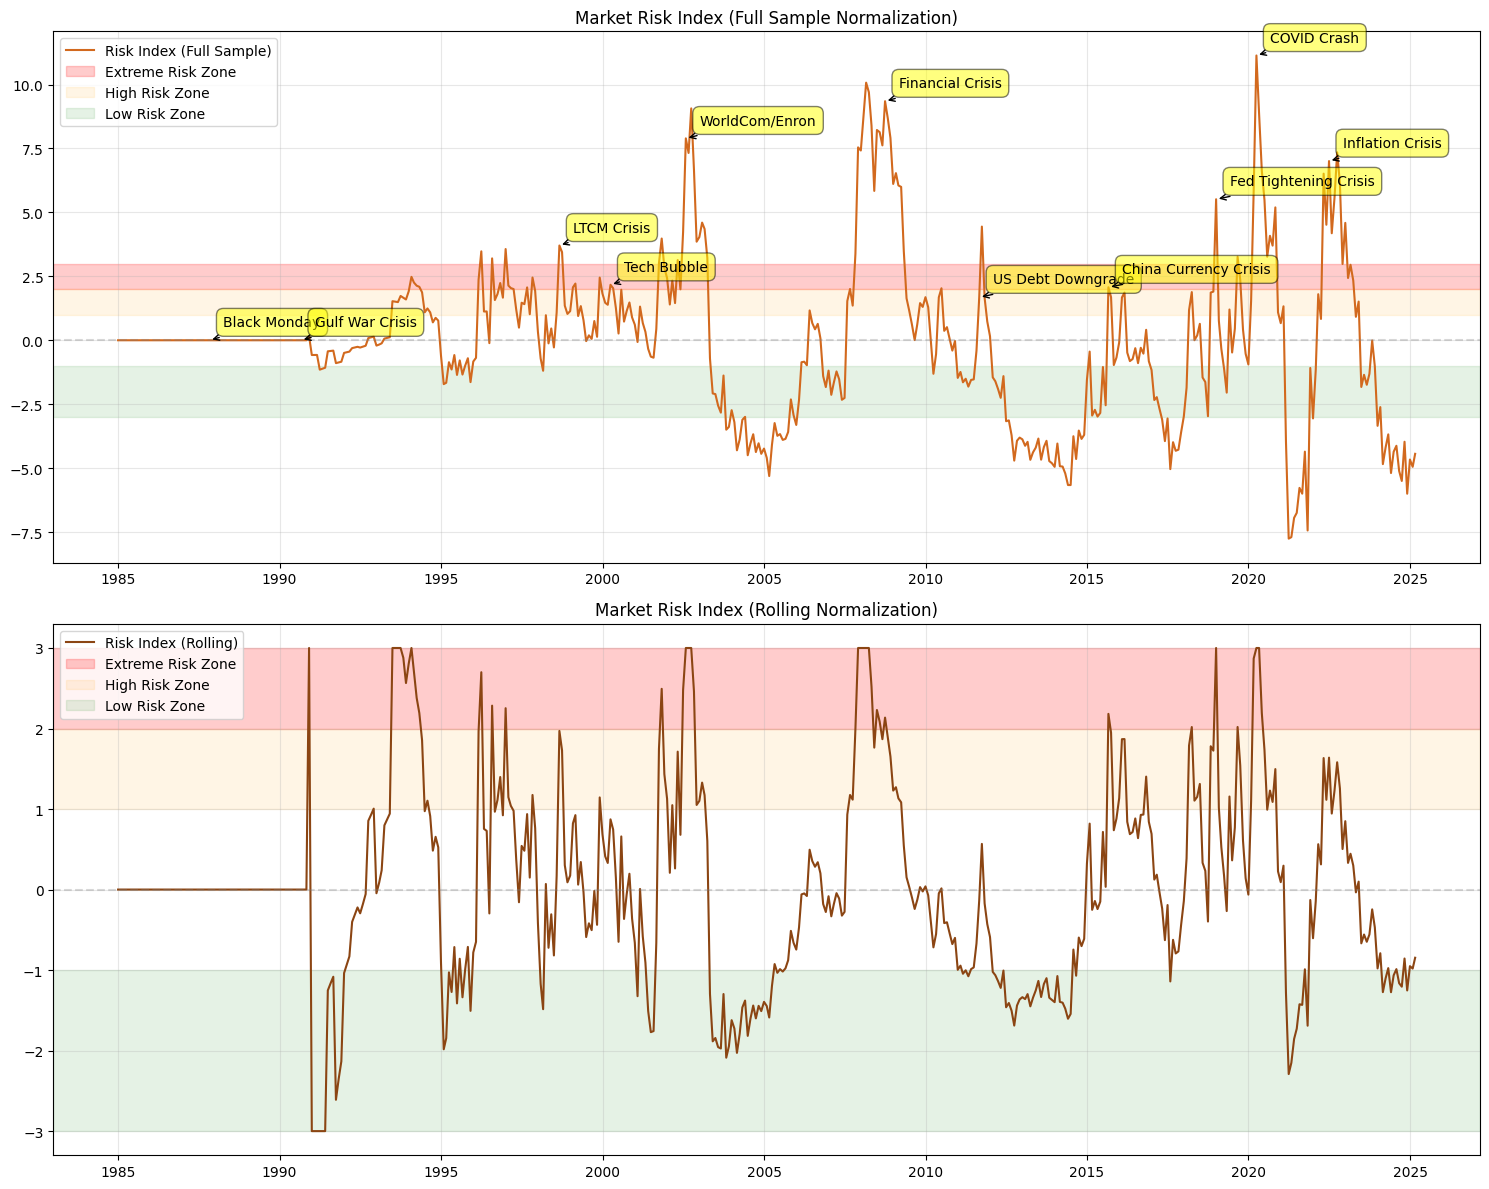

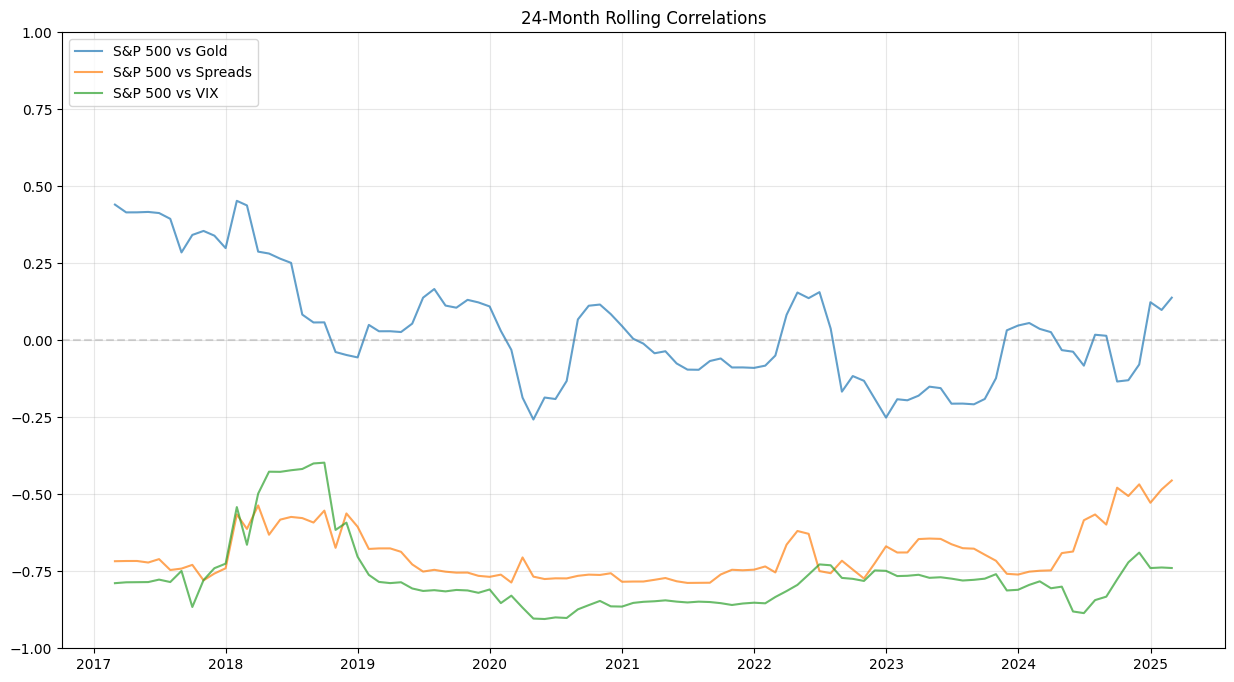


Current Risk Assessment:
--------------------------------------------------
Full Sample Risk Index:
Value: -4.44
Percentile: 6.6%

Rolling Risk Index:
Value: -0.85
Percentile: 25.5%

Risk Status:
Current Status: MODERATE RISK
Assessment: Normal market conditions

Component Analysis:
Market Returns: 0.31
Market Volatility: -2.34
VIX: -0.78
Gold: 1.36
Credit Spreads: -1.12


<ipython-input-20-6764f20d2b93>:203: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_static = df['Risk_Index_Static'].dropna()[-1]
<ipython-input-20-6764f20d2b93>:204: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rolling = df['Risk_Index_Rolling'].dropna()[-1]
<ipython-input-20-6764f20d2b93>:243: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Market Returns': df['SP500_zscore'].dropna()[-1],
<ipython-input-20-6764f20d2b

In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

def get_market_data(start_date='1980-01-01', end_date=None):
    """Get market data from FRED"""
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print("Downloading data from FRED...")
    try:
        fred = Fred(api_key='9edcfe0388121c02c0de5328c0d75294')

        # Using the EXACT original working series IDs
        sp500 = fred.get_series('SP500', observation_start=start_date, observation_end=end_date)
        gold = fred.get_series('IQ12260', observation_start=start_date, observation_end=end_date)
        corp_spread = fred.get_series('BAMLC0A0CM', observation_start=start_date, observation_end=end_date)
        vix = fred.get_series('VIXCLS', observation_start=start_date, observation_end=end_date)  # Added VIX

        # Resample all series to monthly end dates
        sp500 = sp500.resample('ME').last()
        gold = gold.resample('ME').last()
        corp_spread = corp_spread.resample('ME').last()
        vix = vix.resample('ME').last()

        # Create DataFrame
        market_data = pd.DataFrame({
            'S&P 500': sp500,
            'Gold': gold,
            'Corporate Spread': corp_spread,
            'VIX': vix
        })

        # Fill missing values
        market_data = market_data.fillna(method='ffill')

        print("\nData Summary:")
        print(market_data.info())
        print("\nFirst few rows:")
        print(market_data.head())

        return market_data

    except Exception as e:
        print(f"Error getting data from FRED: {str(e)}")
        return None

def rolling_zscore(series, window=60):  # 5-year window
    """Calculate rolling z-score with improved handling of extremes"""
    if series.empty:
        return pd.Series()
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    zscore = (series - rolling_mean) / rolling_std
    # Winsorize extreme values at ±3
    return np.clip(zscore, -3, 3).fillna(0)

def calculate_risk_indices(df):
    """Calculate risk indices with improved methodology"""
    if df is None or df.empty:
        print("No data available for risk calculation")
        return None

    try:
        # Calculate returns and volatility metrics
        df['SP500_ret'] = df['S&P 500'].pct_change(12)  # 12-month returns
        df['SP500_vol'] = df['S&P 500'].pct_change().rolling(window=22).std() * np.sqrt(252)  # Annualized volatility
        df['Gold_ret'] = df['Gold'].pct_change(12)
        df['VIX_level'] = df['VIX']

        # Use spread levels directly
        df['Spread_level'] = df['Corporate Spread']

        # Calculate z-scores with 5-year window
        window = 60
        df['SP500_zscore'] = rolling_zscore(df['SP500_ret'], window)
        df['Vol_zscore'] = rolling_zscore(df['SP500_vol'], window)
        df['VIX_zscore'] = rolling_zscore(df['VIX_level'], window)
        df['Gold_zscore'] = rolling_zscore(df['Gold_ret'], window)
        df['Spread_zscore'] = rolling_zscore(df['Spread_level'], window)

        # Calculate risk indices with adjusted weights
        df['Risk_Index_Static'] = (-2.0 * df['SP500_zscore'] +  # Increased weight for market returns
                                  1.0 * df['Gold_zscore'] +
                                  1.5 * df['Spread_zscore'] +
                                  1.5 * df['VIX_zscore'] +      # Added VIX component
                                  1.0 * df['Vol_zscore'])       # Added realized volatility

        # Calculate dynamic risk index
        df['Risk_Index_Rolling'] = rolling_zscore(df['Risk_Index_Static'], window)

        return df
    except Exception as e:
        print(f"Error calculating risk indices: {str(e)}")
        return None

def plot_risk_indices(df):
    """Create visualization of risk indices with expanded crash annotations"""
    if df is None or df.empty:
        print("No data available for plotting")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Static index plot
        ax1.plot(df.index, df['Risk_Index_Static'], color='#D2691E', linewidth=1.5,
                 label='Risk Index (Full Sample)')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax1.axhspan(2.0, 3.0, color='red', alpha=0.2, label='Extreme Risk Zone')
        ax1.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk Zone')
        ax1.axhspan(-3.0, -1.0, color='green', alpha=0.1, label='Low Risk Zone')
        ax1.set_title('Market Risk Index (Full Sample Normalization)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # Expanded crash annotations
        crashes = {
            '1987-10': 'Black Monday',
            '1990-08': 'Gulf War Crisis',
            '1998-08': 'LTCM Crisis',
            '2000-03': 'Tech Bubble',
            '2002-07': 'WorldCom/Enron',
            '2008-09': 'Financial Crisis',
            '2011-08': 'US Debt Downgrade',
            '2015-08': 'China Currency Crisis',
            '2018-12': 'Fed Tightening Crisis',
            '2020-03': 'COVID Crash',
            '2022-06': 'Inflation Crisis'
        }

        for date, label in crashes.items():
            try:
                idx = df.index.get_loc(date)
                ax1.annotate(label,
                           xy=(df.index[idx], df['Risk_Index_Static'][idx]),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            except:
                continue

        # Rolling index plot with improved thresholds
        ax2.plot(df.index, df['Risk_Index_Rolling'], color='#8B4513', linewidth=1.5,
                 label='Risk Index (Rolling)')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(2.0, 3.0, color='red', alpha=0.2, label='Extreme Risk Zone')
        ax2.axhspan(1.0, 2.0, color='orange', alpha=0.1, label='High Risk Zone')
        ax2.axhspan(-3.0, -1.0, color='green', alpha=0.1, label='Low Risk Zone')
        ax2.set_title('Market Risk Index (Rolling Normalization)')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting risk indices: {str(e)}")

def plot_correlations(df):
    """Plot rolling correlations with improved metrics"""
    if df is None or df.empty:
        print("No data available for correlation analysis")
        return

    try:
        # Calculate returns and changes
        df['S&P_ret'] = df['S&P 500'].pct_change()
        df['Gold_ret'] = df['Gold'].pct_change()
        df['Spread_change'] = df['Corporate Spread'].diff()
        df['VIX_change'] = df['VIX'].diff()

        # Calculate rolling correlations with longer window
        window = 24  # Changed to 24 months for more stable correlations
        corr_sg = df['S&P_ret'].rolling(window).corr(df['Gold_ret'])
        corr_sc = df['S&P_ret'].rolling(window).corr(df['Spread_change'])
        corr_sv = df['S&P_ret'].rolling(window).corr(df['VIX_change'])

        # Plot
        plt.figure(figsize=(15, 8))
        plt.plot(corr_sg.index, corr_sg.values, label='S&P 500 vs Gold', alpha=0.7)
        plt.plot(corr_sc.index, corr_sc.values, label='S&P 500 vs Spreads', alpha=0.7)
        plt.plot(corr_sv.index, corr_sv.values, label='S&P 500 vs VIX', alpha=0.7)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.title('24-Month Rolling Correlations')
        plt.legend(loc='upper left')
        plt.ylim(-1, 1)
        plt.show()
    except Exception as e:
        print(f"Error plotting correlations: {str(e)}")

def print_risk_analysis(df):
    """Print detailed risk analysis with improved thresholds and metrics"""
    if df is None or df.empty:
        print("No data available for risk analysis")
        return

    try:
        latest_static = df['Risk_Index_Static'].dropna()[-1]
        latest_rolling = df['Risk_Index_Rolling'].dropna()[-1]

        print("\nCurrent Risk Assessment:")
        print("-" * 50)

        # Static index analysis
        print("Full Sample Risk Index:")
        print(f"Value: {latest_static:.2f}")
        print(f"Percentile: {stats.percentileofscore(df['Risk_Index_Static'].dropna(), latest_static):.1f}%")

        # Rolling index analysis
        print("\nRolling Risk Index:")
        print(f"Value: {latest_rolling:.2f}")
        print(f"Percentile: {stats.percentileofscore(df['Risk_Index_Rolling'].dropna(), latest_rolling):.1f}%")

        # Risk status with more granular thresholds
        print("\nRisk Status:")
        if latest_rolling > 2.0:
            status = "EXTREME RISK"
            detail = "Market conditions indicate potential for severe market stress"
        elif latest_rolling > 1.0:
            status = "HIGH RISK"
            detail = "Market conditions suggest elevated risk of decline"
        elif latest_rolling < -2.0:
            status = "VERY LOW RISK"
            detail = "Market conditions appear highly favorable"
        elif latest_rolling < -1.0:
            status = "LOW RISK"
            detail = "Market conditions appear favorable"
        else:
            status = "MODERATE RISK"
            detail = "Normal market conditions"

        print(f"Current Status: {status}")
        print(f"Assessment: {detail}")

        # Add component analysis
        print("\nComponent Analysis:")
        latest_components = {
            'Market Returns': df['SP500_zscore'].dropna()[-1],
            'Market Volatility': df['Vol_zscore'].dropna()[-1],
            'VIX': df['VIX_zscore'].dropna()[-1],
            'Gold': df['Gold_zscore'].dropna()[-1],
            'Credit Spreads': df['Spread_zscore'].dropna()[-1]
        }

        for component, value in latest_components.items():
            print(f"{component}: {value:.2f}")

    except Exception as e:
        print(f"Error in risk analysis: {str(e)}")

def main():
    # Get data from FRED
    df = get_market_data()
    if df is not None:
        # Calculate risk indices
        df = calculate_risk_indices(df)
        if df is not None:
            # Create visualizations
            plot_risk_indices(df)
            plot_correlations(df)
            # Print analysis
            print_risk_analysis(df)
    else:
        print("Unable to proceed due to data retrieval issues")

if __name__ == "__main__":
    main()

<ipython-input-19-7b09a8440d61>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_data = market_data.fillna(method='ffill')



Data Summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483 entries, 1984-12-31 to 2025-02-28
Freq: ME
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   S&P 500           121 non-null    float64
 1   Gold              483 non-null    float64
 2   Corporate Spread  339 non-null    float64
dtypes: float64(3)
memory usage: 31.3 KB
None

First few rows:
            S&P 500   Gold  Corporate Spread
1984-12-31      NaN  120.3               NaN
1985-01-31      NaN  120.3               NaN
1985-02-28      NaN  120.3               NaN
1985-03-31      NaN  104.7               NaN
1985-04-30      NaN  104.7               NaN


/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


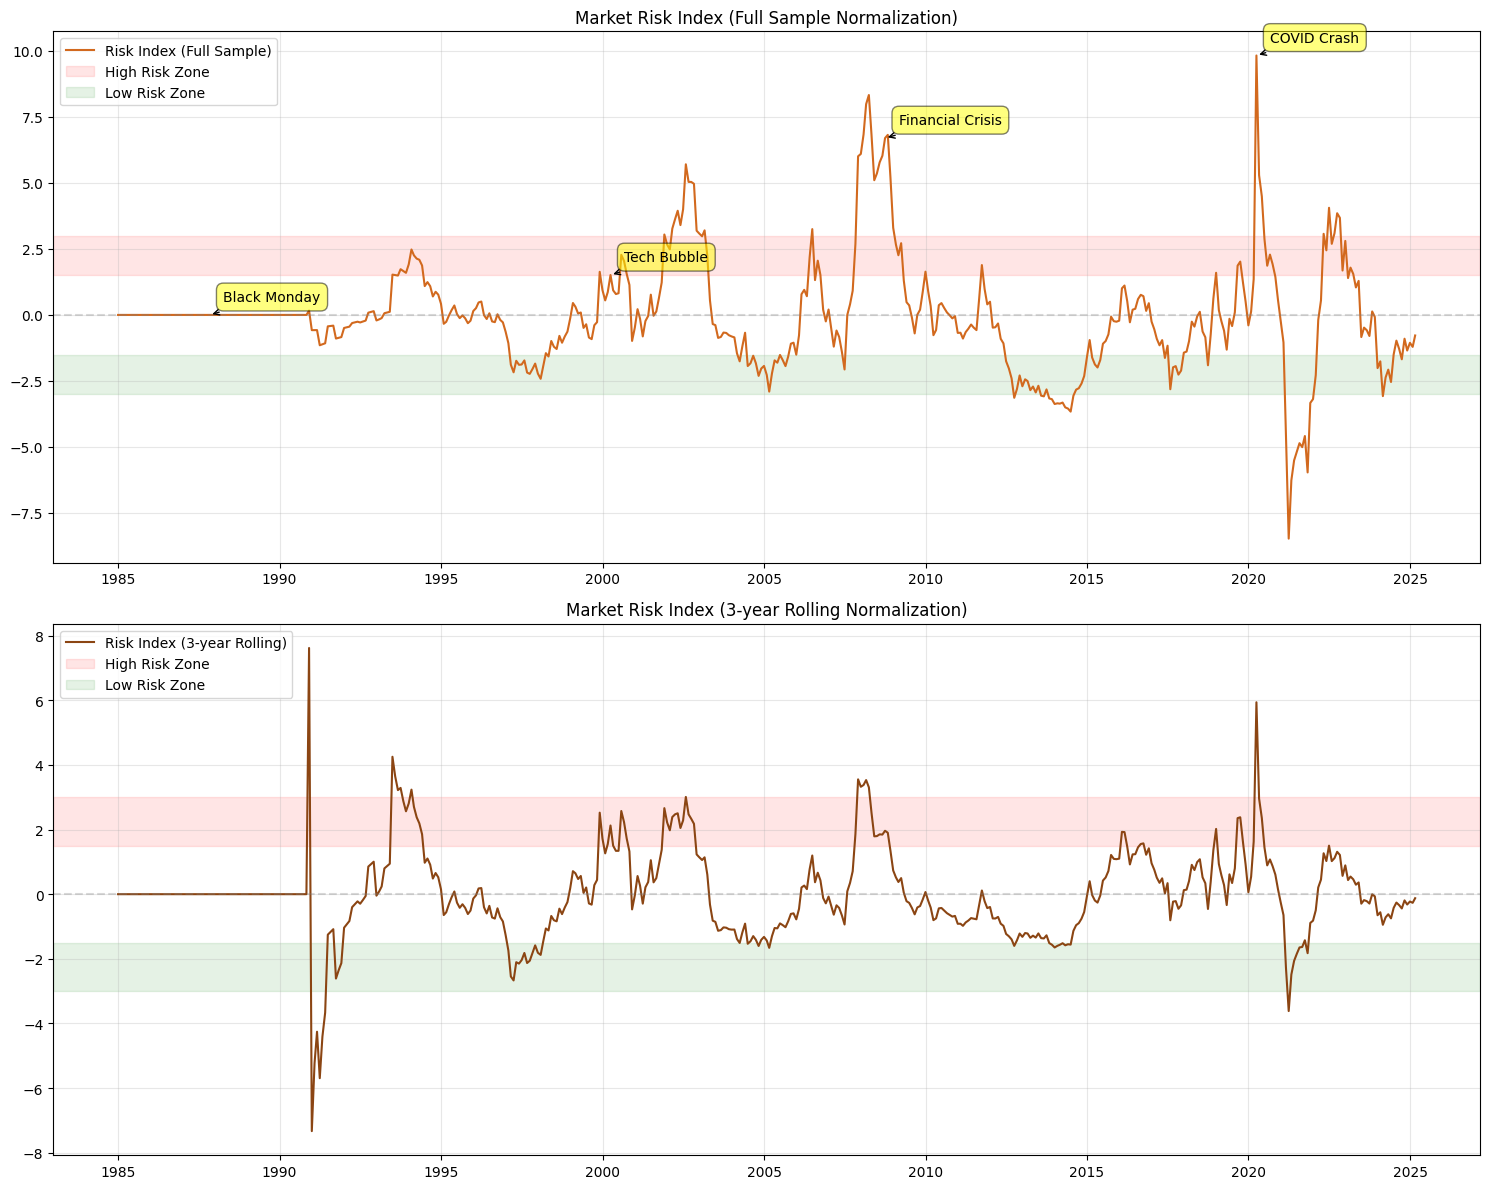

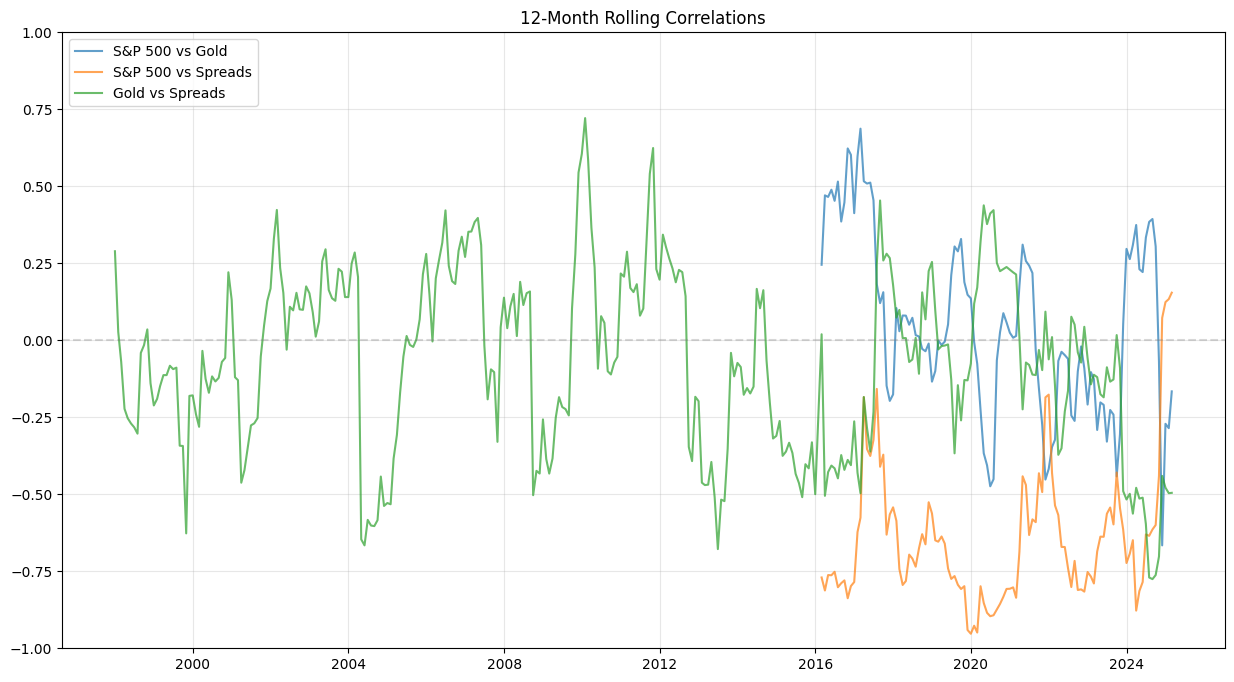


Current Risk Assessment:
--------------------------------------------------
Full Sample Risk Index:
Value: -0.78
Percentile: 30.8%

Rolling Risk Index:
Value: -0.12
Percentile: 44.3%

Risk Status:
Current Status: MODERATE RISK
Assessment: Normal market conditions


<ipython-input-19-7b09a8440d61>:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_static = df['Risk_Index_Static'].dropna()[-1]
<ipython-input-19-7b09a8440d61>:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_rolling = df['Risk_Index_Rolling'].dropna()[-1]


In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

def get_market_data(start_date='1980-01-01', end_date=None):
    """Get market data from FRED"""
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print("Downloading data from FRED...")
    try:
        fred = Fred(api_key='9edcfe0388121c02c0de5328c0d75294')

        # Using the EXACT original working series IDs
        sp500 = fred.get_series('SP500', observation_start=start_date, observation_end=end_date)
        gold = fred.get_series('IQ12260', observation_start=start_date, observation_end=end_date)
        corp_spread = fred.get_series('BAMLC0A0CM', observation_start=start_date, observation_end=end_date)

        # Resample all series to monthly end dates
        sp500 = sp500.resample('ME').last()
        gold = gold.resample('ME').last()
        corp_spread = corp_spread.resample('ME').last()

        # Create DataFrame
        market_data = pd.DataFrame({
            'S&P 500': sp500,
            'Gold': gold,
            'Corporate Spread': corp_spread
        })

        # Fill missing values
        market_data = market_data.fillna(method='ffill')

        print("\nData Summary:")
        print(market_data.info())
        print("\nFirst few rows:")
        print(market_data.head())

        return market_data

    except Exception as e:
        print(f"Error getting data from FRED: {str(e)}")
        return None

def rolling_zscore(series, window=60):  # Changed to 5-year window (60 months)
    """Calculate rolling z-score"""
    if series.empty:
        return pd.Series()
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    zscore = (series - rolling_mean) / rolling_std
    return zscore.fillna(0)

def calculate_risk_indices(df):
    """Calculate risk indices with improved methodology"""
    if df is None or df.empty:
        print("No data available for risk calculation")
        return None

    try:
        # Calculate returns
        df['SP500_ret'] = df['S&P 500'].pct_change(12)  # 12-month returns
        df['SP500_mom'] = df['S&P 500'].pct_change(3)   # 3-month momentum
        df['Gold_ret'] = df['Gold'].pct_change(12)

        # Use spread levels directly
        df['Spread_level'] = df['Corporate Spread']

        # Calculate z-scores with 5-year window
        window = 60  # Changed to 5-year window (60 months)
        df['SP500_zscore'] = rolling_zscore(df['SP500_ret'], window)
        df['Gold_zscore'] = rolling_zscore(df['Gold_ret'], window)
        df['Spread_zscore'] = rolling_zscore(df['Spread_level'], window)

        # Calculate risk indices with adjusted weights
        df['Risk_Index_Static'] = (-1.5 * df['SP500_zscore'] +
                                  1.0 * df['Gold_zscore'] +
                                  1.5 * df['Spread_zscore'])

        df['Risk_Index_Rolling'] = rolling_zscore(df['Risk_Index_Static'], window)

        return df
    except Exception as e:
        print(f"Error calculating risk indices: {str(e)}")
        return None

def plot_risk_indices(df):
    """Create visualization of risk indices with crash annotations"""
    if df is None or df.empty:
        print("No data available for plotting")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Static index plot
        ax1.plot(df.index, df['Risk_Index_Static'], color='#D2691E', linewidth=1.5,
                 label='Risk Index (Full Sample)')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax1.axhspan(1.5, 3, color='red', alpha=0.1, label='High Risk Zone')
        ax1.axhspan(-3, -1.5, color='green', alpha=0.1, label='Low Risk Zone')
        ax1.set_title('Market Risk Index (Full Sample Normalization)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # Add crash annotations
        crashes = {
            '1987-10': 'Black Monday',
            '2000-03': 'Tech Bubble',
            '2008-09': 'Financial Crisis',
            '2020-03': 'COVID Crash'
        }

        for date, label in crashes.items():
            try:
                idx = df.index.get_loc(date)
                ax1.annotate(label,
                           xy=(df.index[idx], df['Risk_Index_Static'][idx]),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            except:
                continue

        # Rolling index plot
        ax2.plot(df.index, df['Risk_Index_Rolling'], color='#8B4513', linewidth=1.5,
                 label='Risk Index (3-year Rolling)')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(1.5, 3, color='red', alpha=0.1, label='High Risk Zone')
        ax2.axhspan(-3, -1.5, color='green', alpha=0.1, label='Low Risk Zone')
        ax2.set_title('Market Risk Index (3-year Rolling Normalization)')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting risk indices: {str(e)}")

def plot_correlations(df):
    """Plot rolling correlations"""
    if df is None or df.empty:
        print("No data available for correlation analysis")
        return

    try:
        # Calculate returns and changes
        df['S&P_ret'] = df['S&P 500'].pct_change()
        df['Gold_ret'] = df['Gold'].pct_change()
        df['Spread_change'] = df['Corporate Spread'].diff()  # Changed to diff() for spreads

        # Calculate rolling correlations
        window = 12
        corr_sg = df['S&P_ret'].rolling(window).corr(df['Gold_ret'])
        corr_sc = df['S&P_ret'].rolling(window).corr(df['Spread_change'])
        corr_gc = df['Gold_ret'].rolling(window).corr(df['Spread_change'])

        # Plot
        plt.figure(figsize=(15, 8))
        plt.plot(corr_sg.index, corr_sg.values, label='S&P 500 vs Gold', alpha=0.7)
        plt.plot(corr_sc.index, corr_sc.values, label='S&P 500 vs Spreads', alpha=0.7)
        plt.plot(corr_gc.index, corr_gc.values, label='Gold vs Spreads', alpha=0.7)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.title('12-Month Rolling Correlations')
        plt.legend(loc='upper left')
        plt.ylim(-1, 1)
        plt.show()
    except Exception as e:
        print(f"Error plotting correlations: {str(e)}")

def print_risk_analysis(df):
    """Print detailed risk analysis with improved thresholds"""
    if df is None or df.empty:
        print("No data available for risk analysis")
        return

    try:
        latest_static = df['Risk_Index_Static'].dropna()[-1]
        latest_rolling = df['Risk_Index_Rolling'].dropna()[-1]

        print("\nCurrent Risk Assessment:")
        print("-" * 50)

        # Static index analysis
        print("Full Sample Risk Index:")
        print(f"Value: {latest_static:.2f}")
        print(f"Percentile: {stats.percentileofscore(df['Risk_Index_Static'].dropna(), latest_static):.1f}%")

        # Rolling index analysis
        print("\nRolling Risk Index:")
        print(f"Value: {latest_rolling:.2f}")
        print(f"Percentile: {stats.percentileofscore(df['Risk_Index_Rolling'].dropna(), latest_rolling):.1f}%")

        # Risk status with adjusted thresholds
        print("\nRisk Status:")
        if latest_rolling > 1.5:
            status = "HIGH RISK"
            detail = "Market conditions suggest elevated risk of significant decline"
        elif latest_rolling < -1.5:
            status = "LOW RISK"
            detail = "Market conditions appear favorable"
        else:
            status = "MODERATE RISK"
            detail = "Normal market conditions"

        print(f"Current Status: {status}")
        print(f"Assessment: {detail}")

    except Exception as e:
        print(f"Error in risk analysis: {str(e)}")

def main():
    # Get data from FRED
    df = get_market_data()
    if df is not None:
        # Calculate risk indices
        df = calculate_risk_indices(df)
        if df is not None:
            # Create visualizations
            plot_risk_indices(df)
            plot_correlations(df)
            # Print analysis
            print_risk_analysis(df)
    else:
        print("Unable to proceed due to data retrieval issues")

if __name__ == "__main__":
    main()

**the one**

In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

def get_market_data(start_date='1980-01-01', end_date=None):
    """Get market data from FRED"""

    # Set end_date to today if not specified
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print("Downloading data from FRED...")
    try:
        # Initialize FRED
        fred = Fred(api_key='9edcfe0388121c02c0de5328c0d75294')

        # Get all data series from FRED
        # SP500 (FRED series 'SP500'), Gold (IQ12260), and Corporate Spread (BAMLC0A0CM)
        sp500 = fred.get_series('SP500', observation_start=start_date, observation_end=end_date)
        gold = fred.get_series('IQ12260', observation_start=start_date, observation_end=end_date)
        corp_spread = fred.get_series('BAMLC0A0CM', observation_start=start_date, observation_end=end_date)

        # Resample all series to monthly end dates
        sp500 = sp500.resample('ME').last()
        gold = gold.resample('ME').last()
        corp_spread = corp_spread.resample('ME').last()

        # Create DataFrame
        market_data = pd.DataFrame({
            'S&P 500': sp500,
            'Gold': gold,
            'Corporate Spread': corp_spread
        })

        # Fill missing values
        market_data = market_data.fillna(method='ffill')

        # Print data info
        print("\nData Summary:")
        print(market_data.info())
        print("\nFirst few rows:")
        print(market_data.head())

        return market_data

    except Exception as e:
        print(f"Error getting data from FRED: {str(e)}")
        return None

def rolling_zscore(series, window=60):
    """Calculate rolling z-score"""
    if series.empty:
        return pd.Series()
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    zscore = (series - rolling_mean) / rolling_std
    return zscore.fillna(0)

def calculate_risk_indices(df):
    """Calculate both static and rolling risk indices"""
    if df is None or df.empty:
        print("No data available for risk calculation")
        return None

    try:
        # Static normalization
        df['S&P_norm_static'] = (df['S&P 500'] - df['S&P 500'].mean()) / df['S&P 500'].std()
        df['Gold_norm_static'] = (df['Gold'] - df['Gold'].mean()) / df['Gold'].std()
        df['Spread_norm_static'] = (df['Corporate Spread'] - df['Corporate Spread'].mean()) / df['Corporate Spread'].std()

        # Rolling normalization
        df['S&P_norm_rolling'] = rolling_zscore(df['S&P 500'])
        df['Gold_norm_rolling'] = rolling_zscore(df['Gold'])
        df['Spread_norm_rolling'] = rolling_zscore(df['Corporate Spread'])

        # Calculate indices
        df['Risk_Index_Static'] = df['S&P_norm_static'] + df['Gold_norm_static'] - df['Spread_norm_static']
        df['Risk_Index_Rolling'] = df['S&P_norm_rolling'] + df['Gold_norm_rolling'] - df['Spread_norm_rolling']

        return df
    except Exception as e:
        print(f"Error calculating risk indices: {str(e)}")
        return None

def plot_risk_indices(df):
    """Create visualization of risk indices"""
    if df is None or df.empty:
        print("No data available for plotting")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Static index plot
        ax1.plot(df.index, df['Risk_Index_Static'], color='#D2691E', linewidth=1.5,
                 label='Risk Index (Full Sample)')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax1.axhspan(2, 4, color='red', alpha=0.1, label='High Risk Zone')
        ax1.axhspan(-4, -2, color='green', alpha=0.1, label='Low Risk Zone')
        ax1.set_title('Market Risk Index (Full Sample Normalization)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # Rolling index plot
        ax2.plot(df.index, df['Risk_Index_Rolling'], color='#8B4513', linewidth=1.5,
                 label='Risk Index (5-year Rolling)')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax2.axhspan(2, 4, color='red', alpha=0.1, label='High Risk Zone')
        ax2.axhspan(-4, -2, color='green', alpha=0.1, label='Low Risk Zone')
        ax2.set_title('Market Risk Index (5-year Rolling Normalization)')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting risk indices: {str(e)}")

def plot_correlations(df):
    """Plot rolling correlations"""
    if df is None or df.empty:
        print("No data available for correlation analysis")
        return

    try:
        # Calculate returns and changes
        df['S&P_ret'] = df['S&P 500'].pct_change()
        df['Gold_ret'] = df['Gold'].pct_change()
        df['Spread_change'] = df['Corporate Spread'].pct_change()

        # Calculate rolling correlations
        window = 12
        corr_sg = df['S&P_ret'].rolling(window).corr(df['Gold_ret'])
        corr_sc = df['S&P_ret'].rolling(window).corr(df['Spread_change'])
        corr_gc = df['Gold_ret'].rolling(window).corr(df['Spread_change'])

        # Plot
        plt.figure(figsize=(15, 8))
        plt.plot(corr_sg.index, corr_sg.values, label='S&P 500 vs Gold', alpha=0.7)
        plt.plot(corr_sc.index, corr_sc.values, label='S&P 500 vs Spreads', alpha=0.7)
        plt.plot(corr_gc.index, corr_gc.values, label='Gold vs Spreads', alpha=0.7)

        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.title('12-Month Rolling Correlations')
        plt.legend(loc='upper left')
        plt.ylim(-1, 1)
        plt.show()
    except Exception as e:
        print(f"Error plotting correlations: {str(e)}")

def print_risk_analysis(df):
    """Print detailed risk analysis"""
    if df is None or df.empty:
        print("No data available for risk analysis")
        return

    try:
        latest_static = df['Risk_Index_Static'].dropna()[-1]
        latest_rolling = df['Risk_Index_Rolling'].dropna()[-1]

        print("\nCurrent Risk Assessment:")
        print("-" * 50)

        # Static index analysis
        print("Full Sample Risk Index:")
        print(f"Value: {latest_static:.2f}")
        print(f"Percentile: {stats.percentileofscore(df['Risk_Index_Static'].dropna(), latest_static):.1f}%")

        # Rolling index analysis
        print("\nRolling Risk Index:")
        print(f"Value: {latest_rolling:.2f}")
        print(f"Percentile: {stats.percentileofscore(df['Risk_Index_Rolling'].dropna(), latest_rolling):.1f}%")

        # Risk status
        print("\nRisk Status:")
        if latest_rolling > 2:
            status = "HIGH RISK"
        elif latest_rolling < -2:
            status = "LOW RISK"
        else:
            status = "MODERATE RISK"
        print(f"Current Status: {status}")
    except Exception as e:
        print(f"Error in risk analysis: {str(e)}")

def main():
    # Get data from FRED
    df = get_market_data()
    if df is not None:
        # Calculate risk indices
        df = calculate_risk_indices(df)
        if df is not None:
            # Create visualizations
            plot_risk_indices(df)
            plot_correlations(df)
            # Print analysis
            print_risk_analysis(df)
    else:
        print("Unable to proceed due to data retrieval issues")

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'fredapi'